In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import cv2
from IPython.display import clear_output
import time
import PIL.Image
from io import BytesIO as StringIO
import IPython.display

In [3]:
import torch
from models import Net,vgg11_conv5_1
img_size = 224
net = vgg11_conv5_1()
model_dir = 'saved_models/'
model_name = 'keypoints_model_finally_vgg.pt'

net.load_state_dict(torch.load(model_dir+model_name,map_location='cpu'))
net.eval()

vgg11_conv5_1(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512,

In [4]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

In [5]:
def detect_faces(img):
    faces = face_cascade.detectMultiScale(img, 1.2, 2)
    image_with_detections = img.copy()
    for (x,y,w,h) in faces:
        cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0), 3) 
    return image_with_detections

In [6]:
def showarray(a, fmt='jpeg'):
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [6]:
def get_frame(cam):
    ret, frame = cam.read()
    frame = cv2.flip(frame, 1)
    return frame

In [8]:
def detect_keypoints(img, scale):
    faces = face_cascade.detectMultiScale(img, 1.2, 2)
    if len(faces) == 0:
        return img
    image_copy = np.copy(img)
    for (x,y,w,h) in faces:
        if (y-scale) < 0 and (x-scale) < 0:
            if (y-scale) < (x-scale):
                scale += (y-scale)
            else:
                scale += (x-scale)
        elif (y-scale) < 0 :
            scale += (y-scale)
        elif (x-scale) < 0:
            scale += (x-scale)
        roi = image_copy[y-scale:y+h+scale, x-scale:x+w+scale]
        roi_color = np.copy(roi)
        roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
        roi = roi/255.0
        h, w = roi.shape
        shape_before_resize = roi.shape
        roi = cv2.resize(roi, (img_size, img_size))
        shape_after_resize = roi.shape
        scaling_factor = shape_before_resize[0]/shape_after_resize[0]
        roi_color = cv2.resize(roi_color, (img_size, img_size))
        roi_copy = np.copy(roi)
        if(len(roi.shape) == 2):
            roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
        roi = roi.transpose((2, 0, 1))
        roi = torch.from_numpy(roi)
        roi = roi.type(torch.FloatTensor)
        
        roi.unsqueeze_(0)
        output_pts = net(roi)
        output_pts = output_pts.view(68, -1)
        output_pts = output_pts.detach().numpy()   
        output_pts = output_pts*(roi_copy.shape[0]/4)+roi_copy.shape[0]/2
        for pts in output_pts:
            pts[0] = x-scale+pts[0]*scaling_factor
            pts[1] = y-scale+pts[1]*scaling_factor
        color = (0,255,0)
        for i in range(len(output_pts)):
            if (i != 16 and i != 21 and i != 26 and i != 30 and i != 35 and i < 68) :
                pt1 = (output_pts[i][0], output_pts[i][1])
                if i == 17:
                    # left eyebrow
                    color = (0,100,0)
                elif i == 22:
                    # right eyebrow
                    color = (0,100,0)
                elif i == 27:
                    # nose stem
                    color = (255,255,0)
                elif i == 31:
                    # nose tip
                    color = (255,255,0)
                elif i == 36:
                    # left eye
                    color = (0,250,154)
                elif i == 42:
                    # right eye
                    color = (0,250,154)
                elif i == 48:
                    # lips
                    color = (255,20,147)
                     
                if i == 41:
                    pt2 = (output_pts[36][0], output_pts[36][1])
                elif i == 47:
                    pt2 = (output_pts[42][0], output_pts[42][1])
                elif i == 67:
                    pt2 = (output_pts[60][0], output_pts[60][1])
                else:
                    pt2 = (output_pts[i+1][0], output_pts[i+1][1])
                    
                cv2.line(image_copy, pt1, pt2, color, thickness=5, lineType=8, shift=0) 
                
        return image_copy

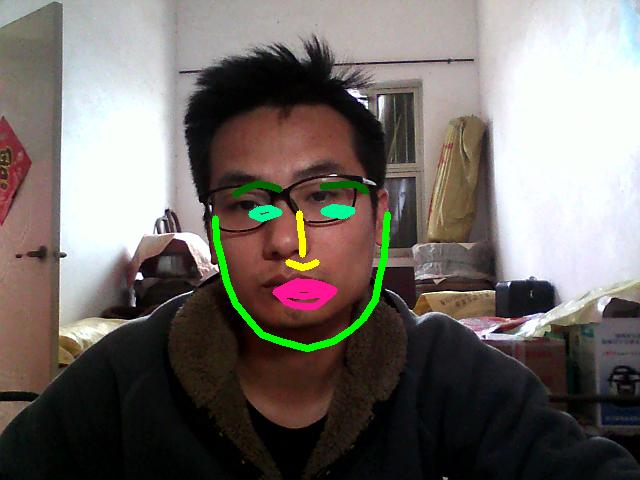

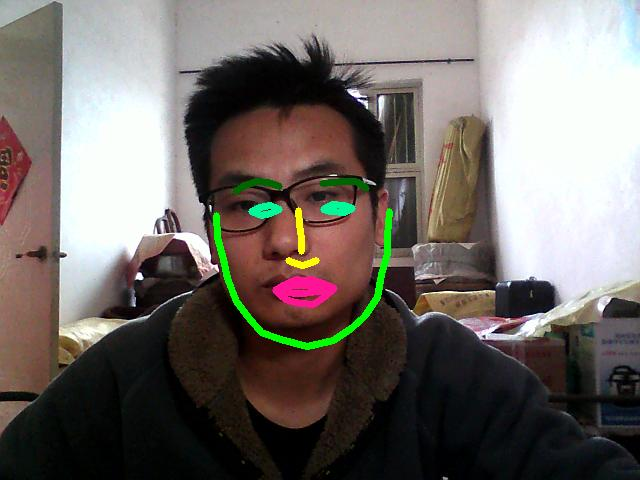

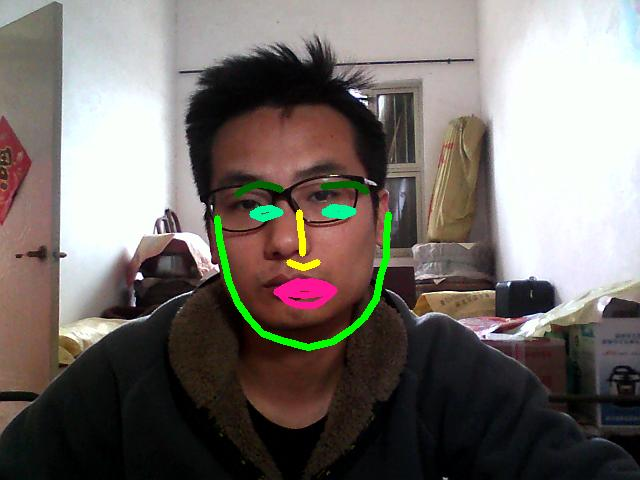

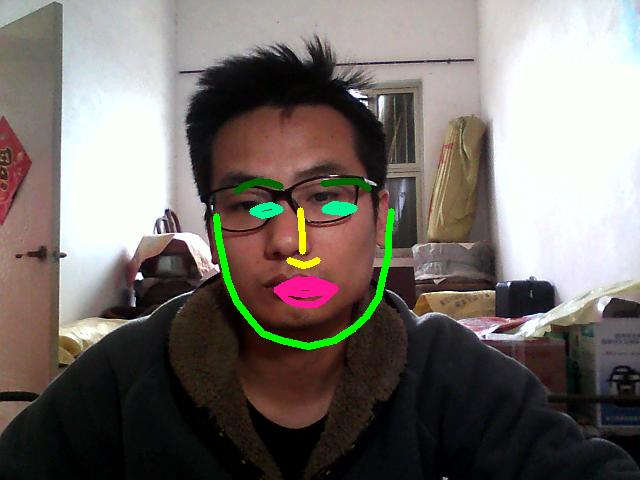

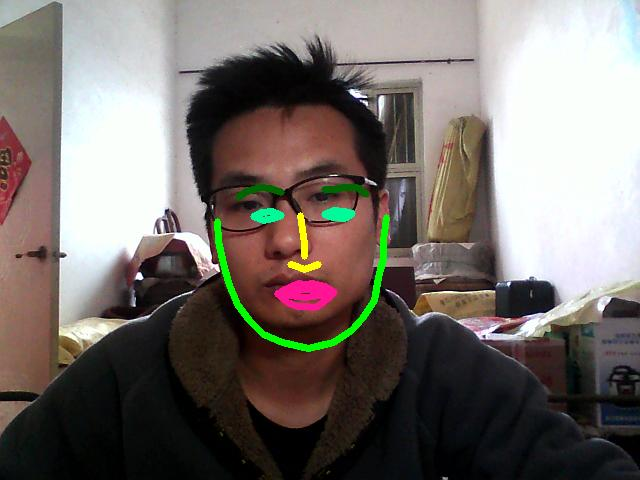

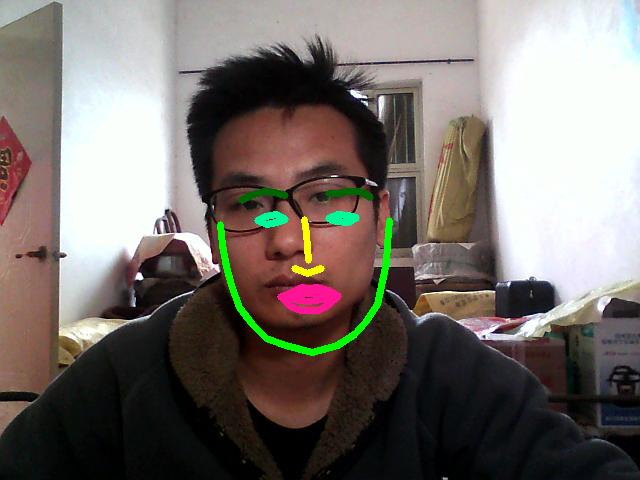

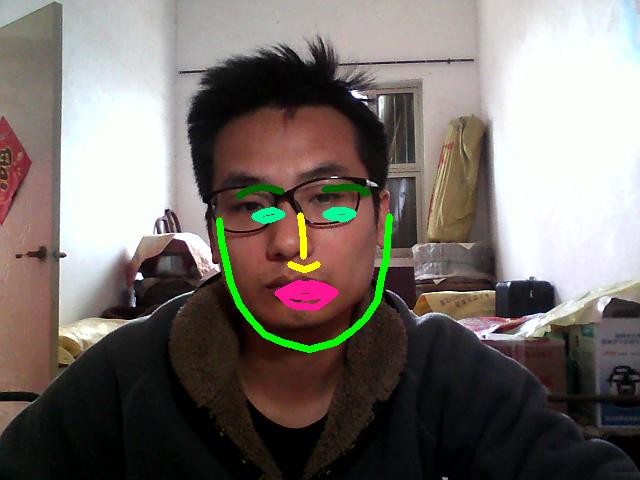

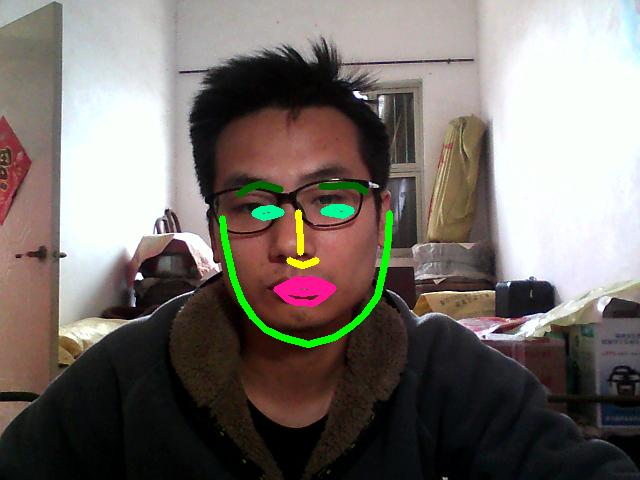

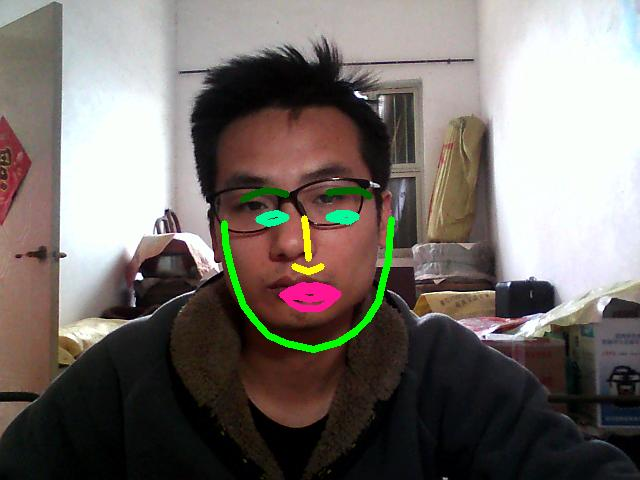

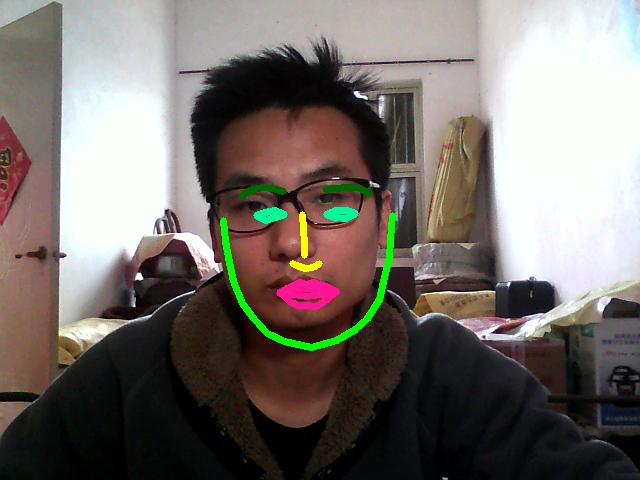

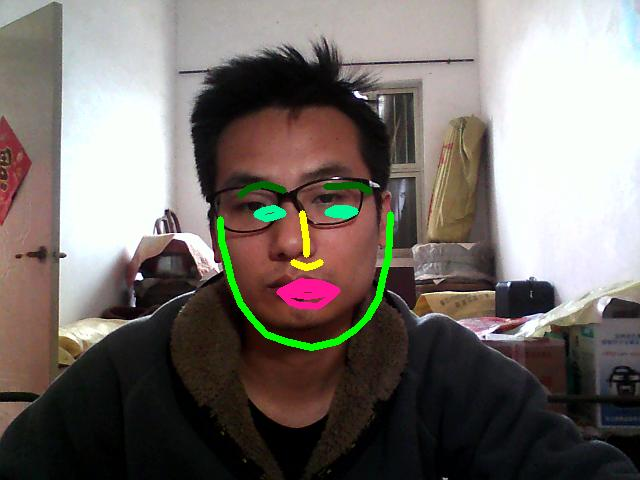

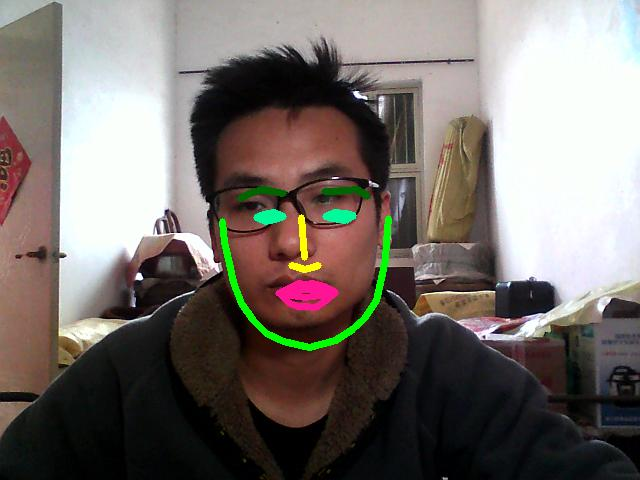

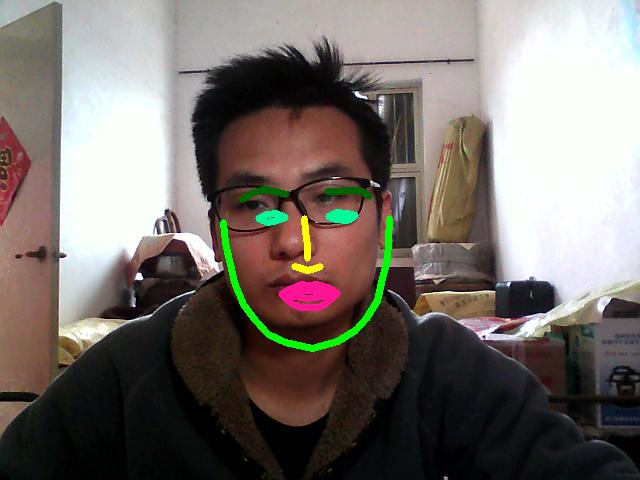

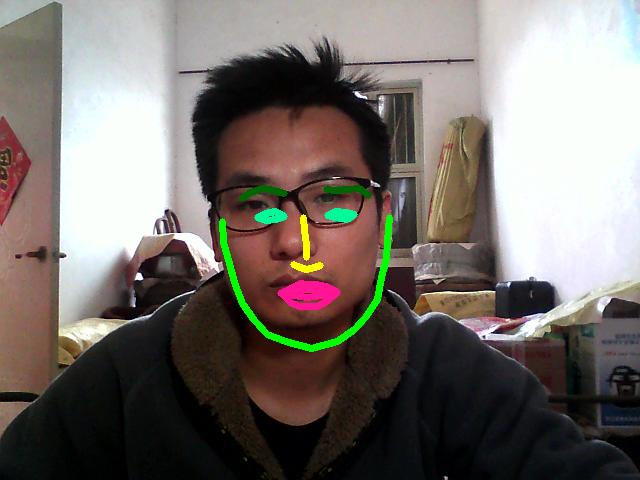

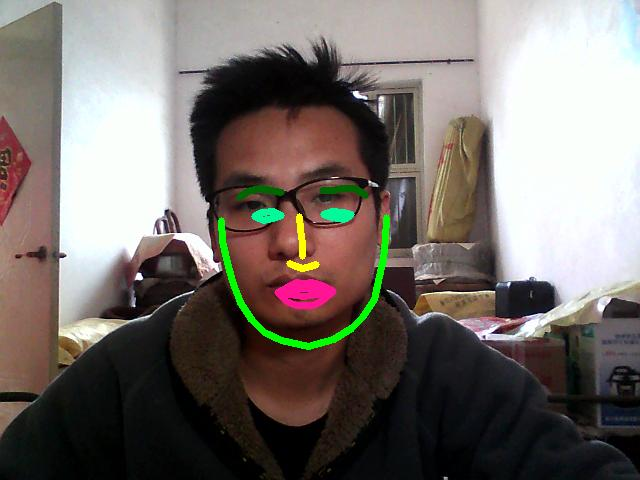

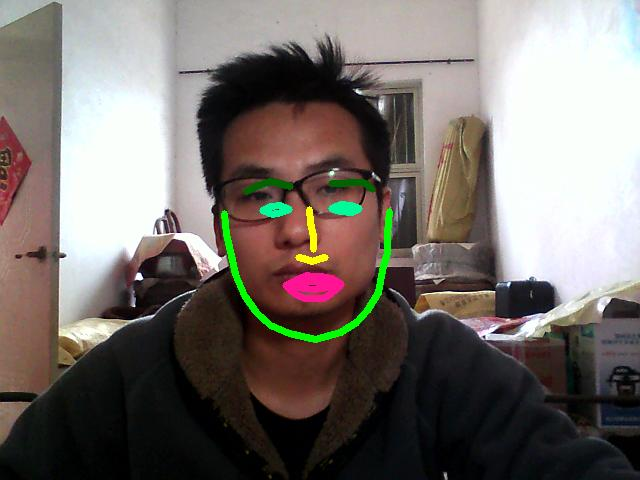

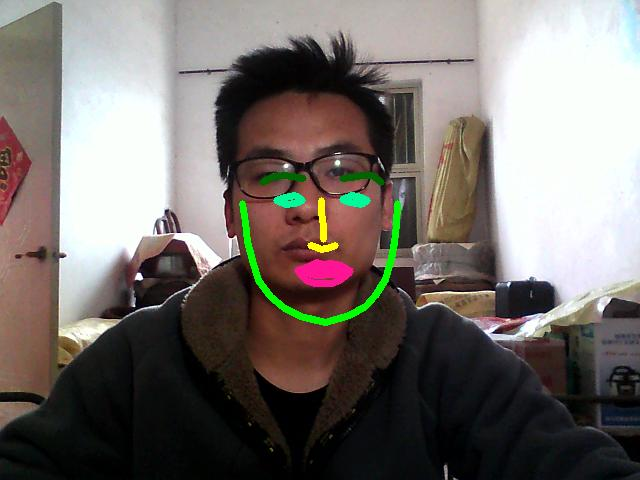

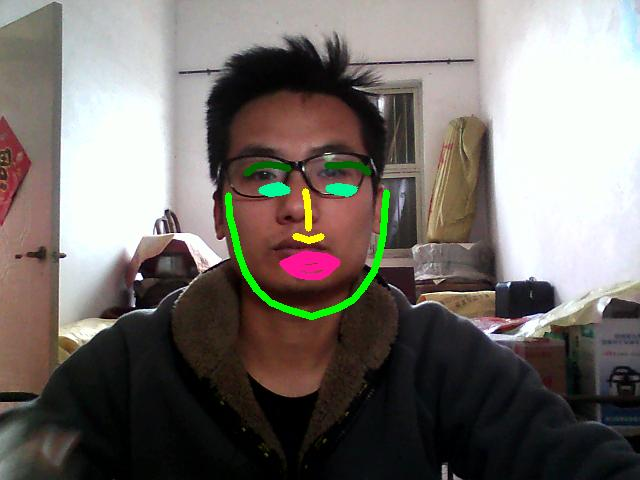

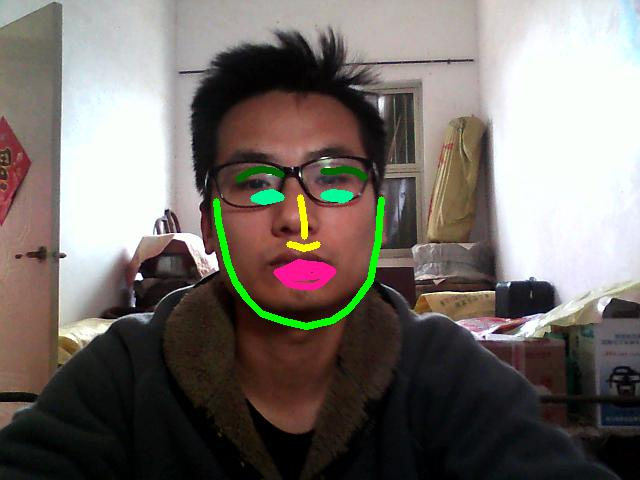

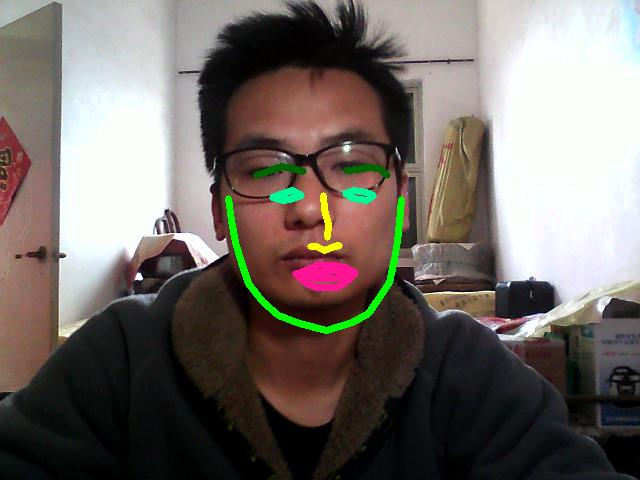

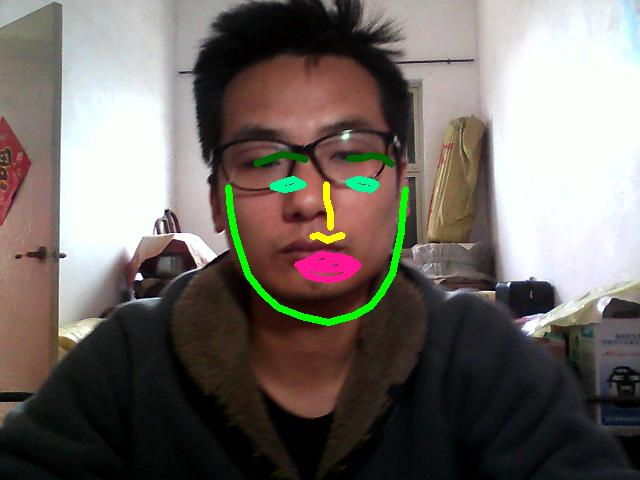

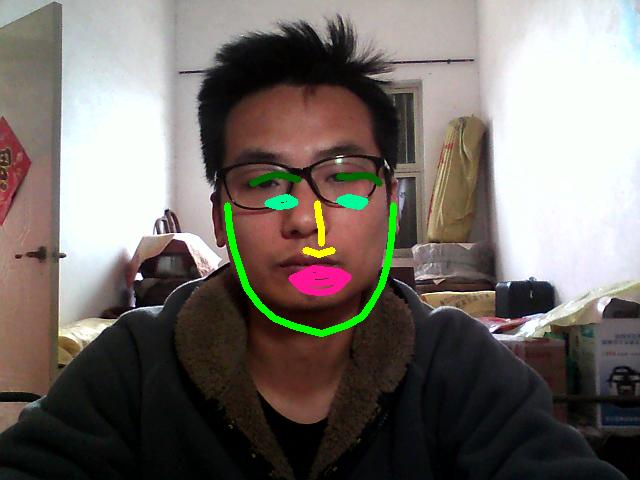

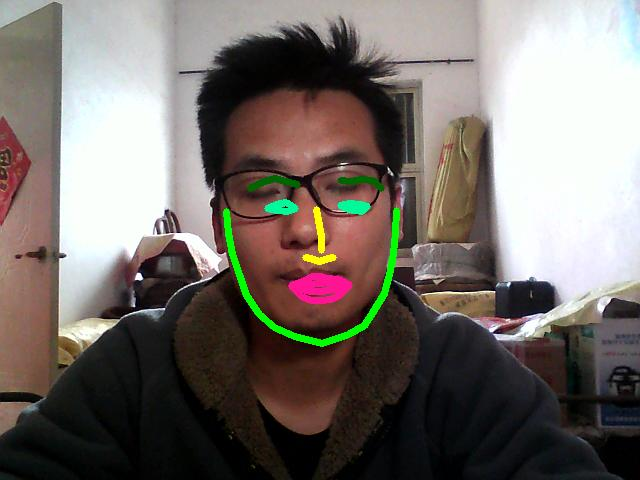

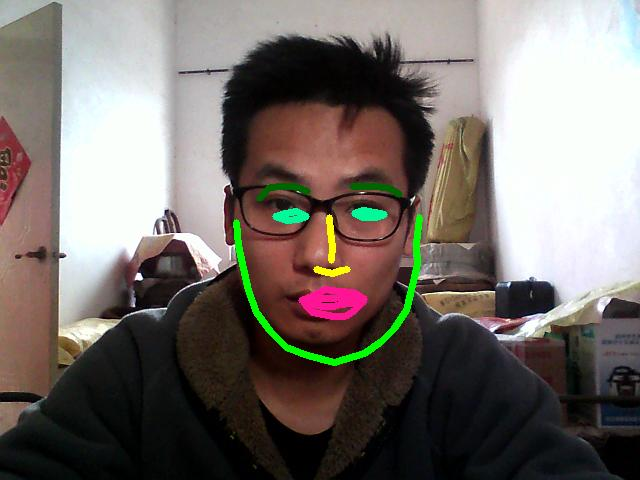

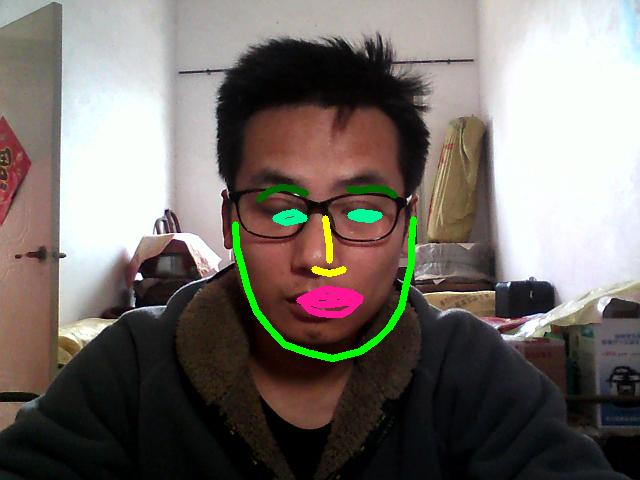

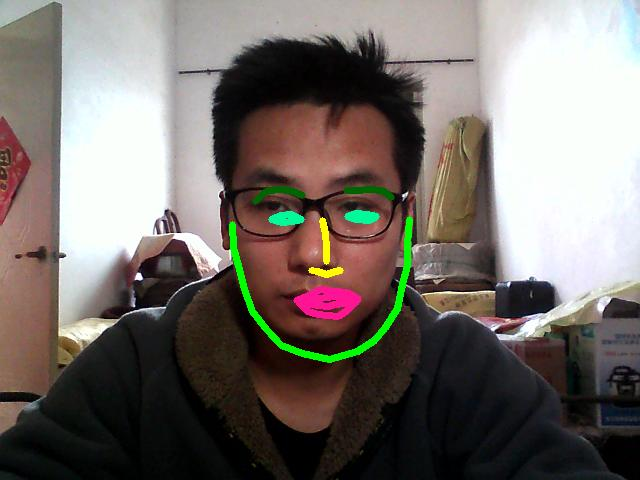

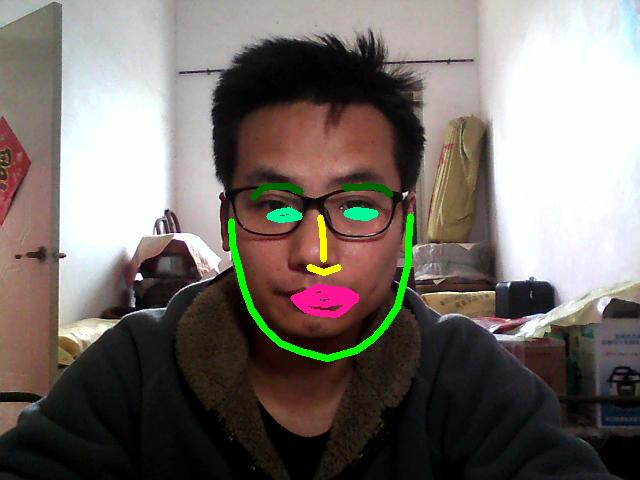

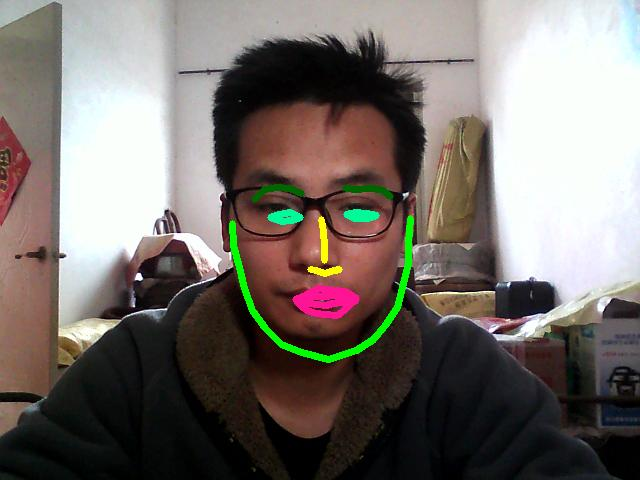

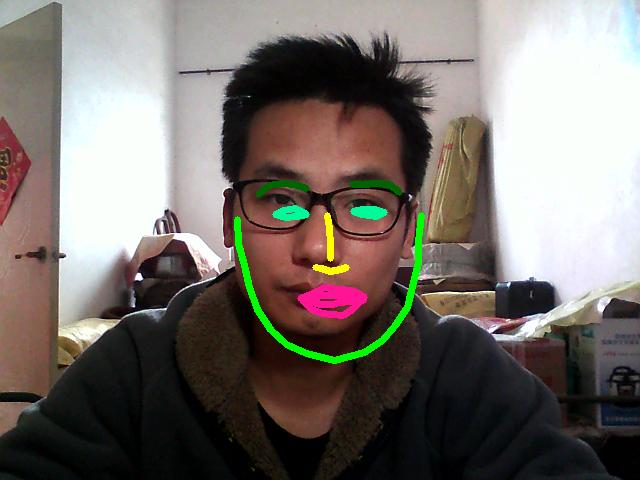

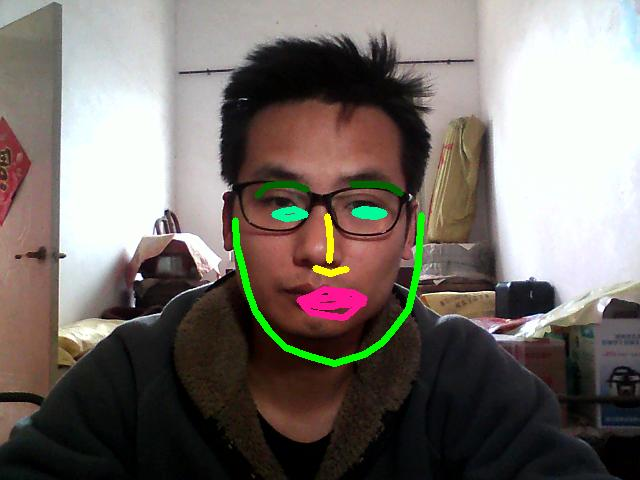

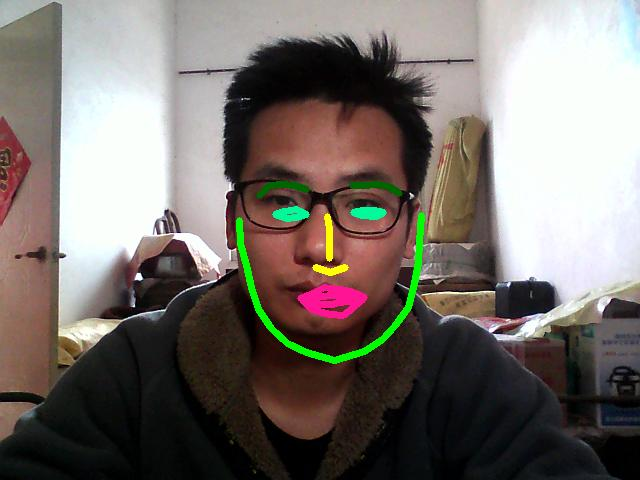

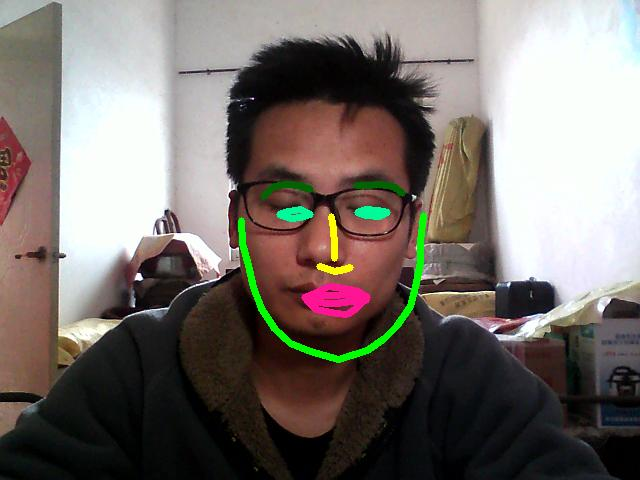

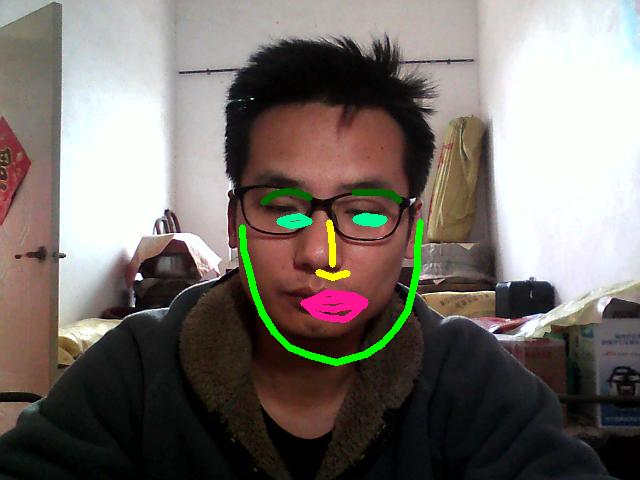

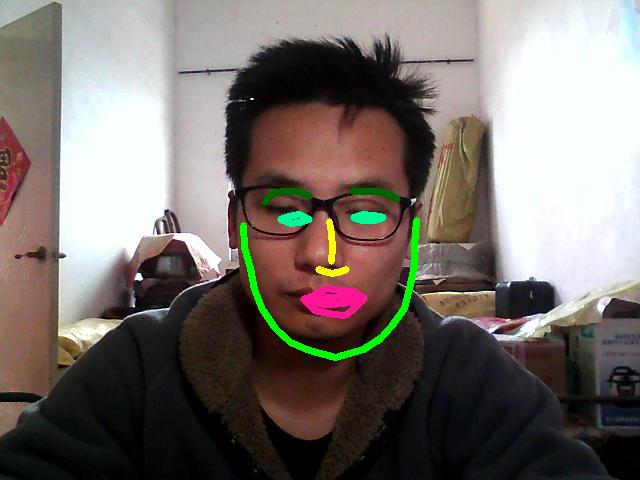

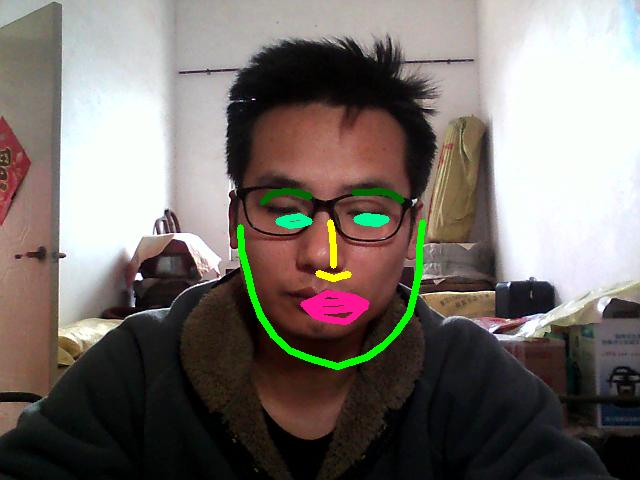

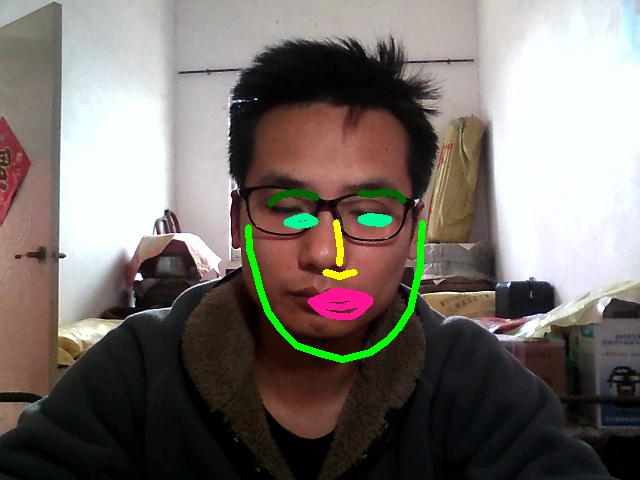

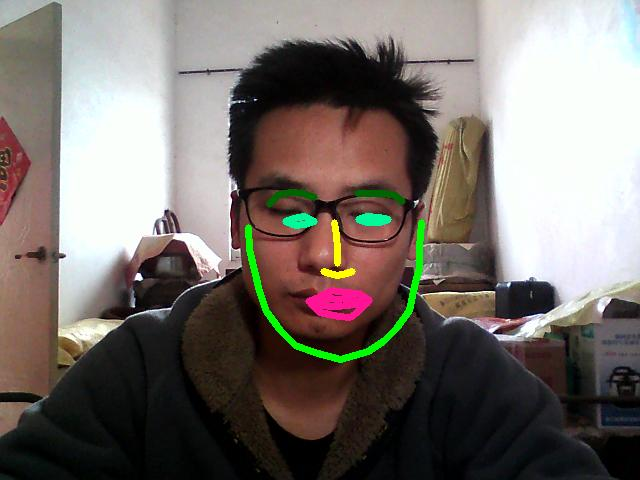

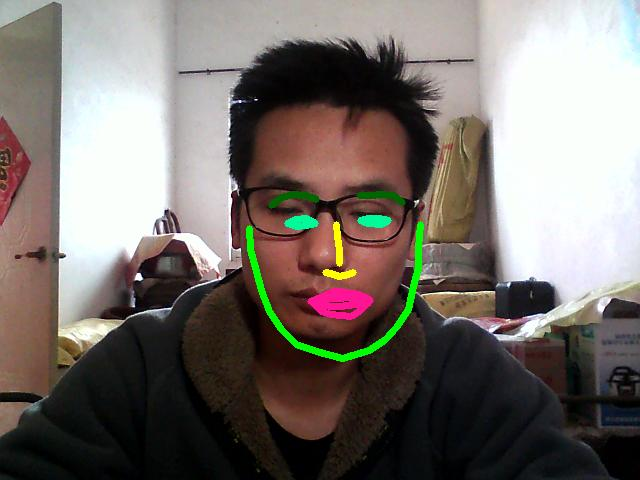

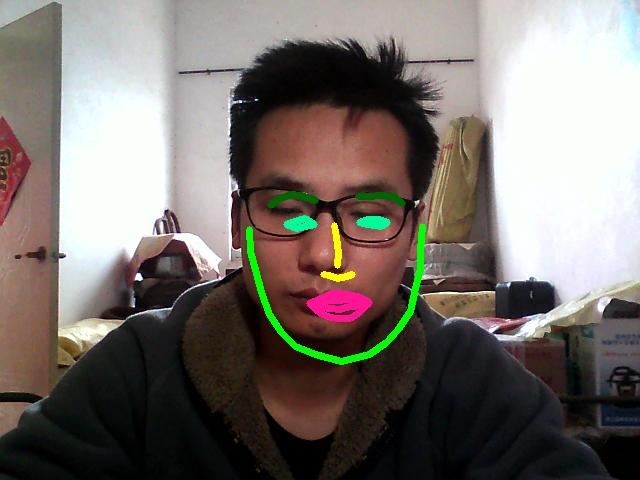

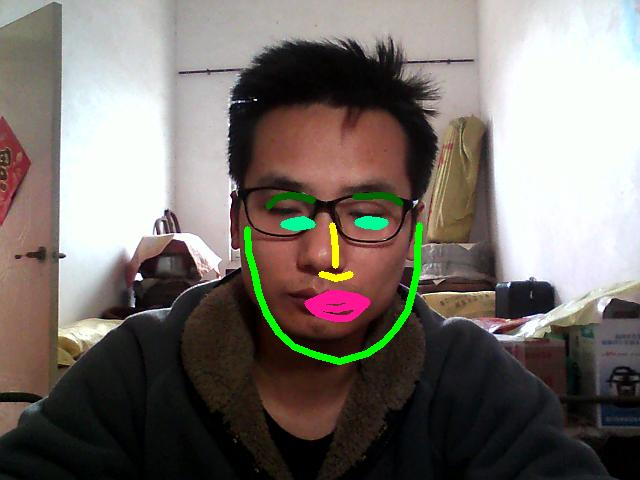

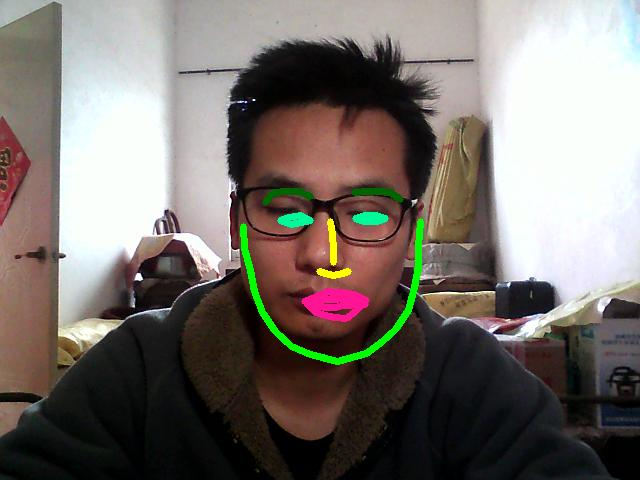

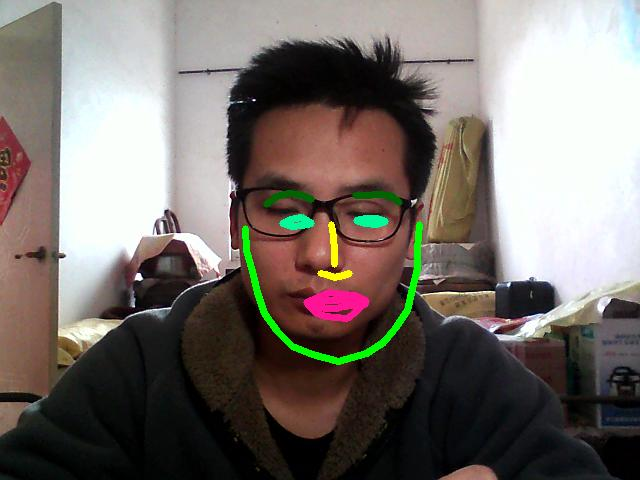

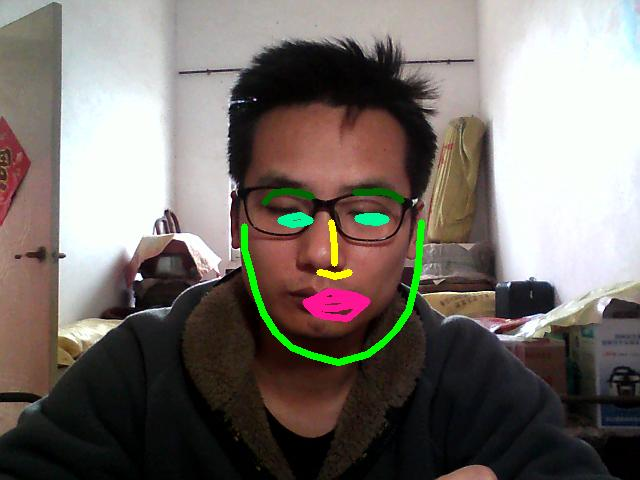

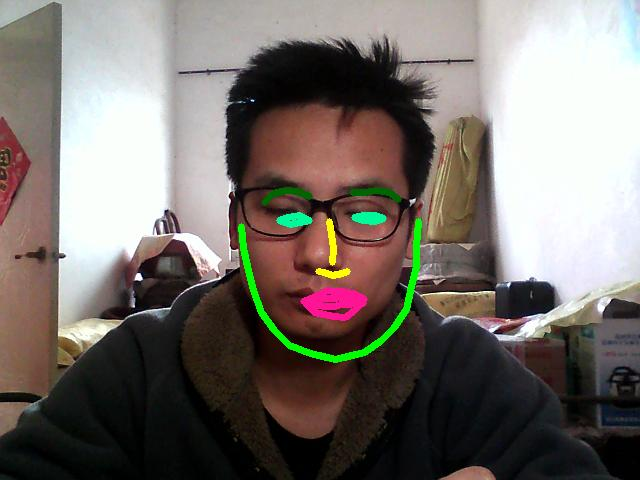

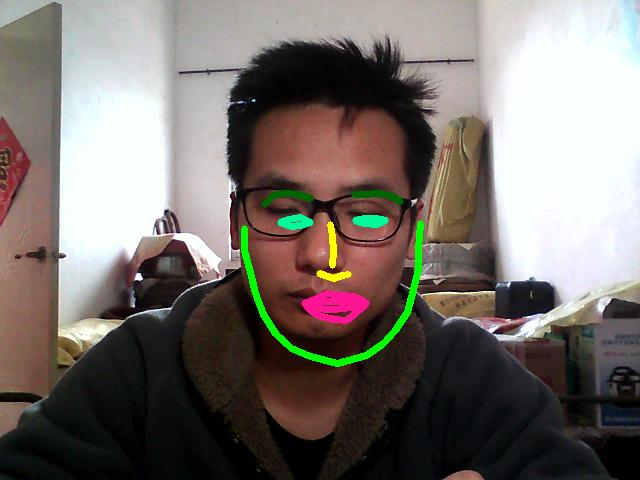

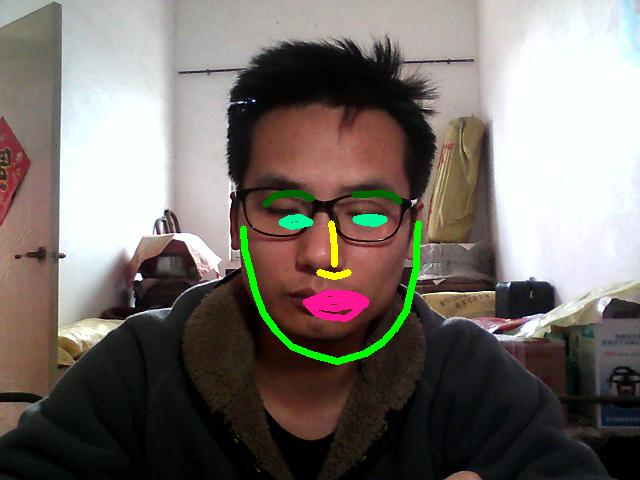

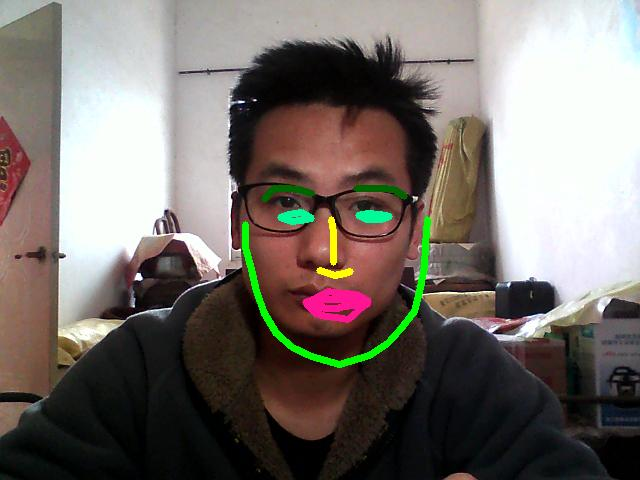

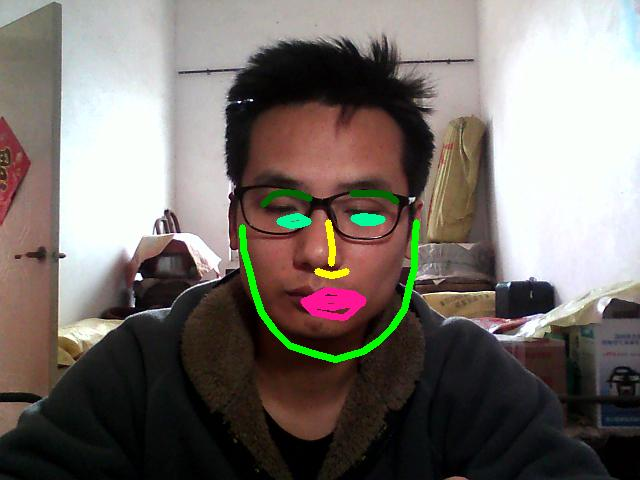

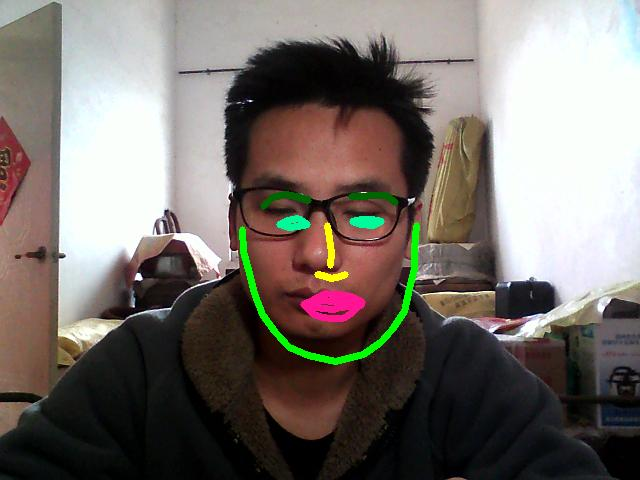

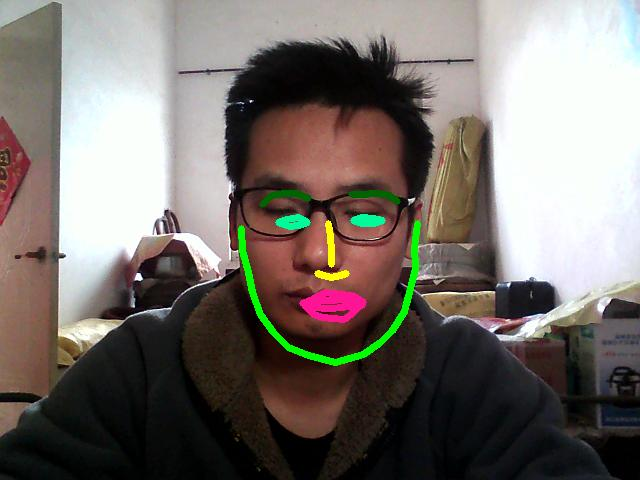

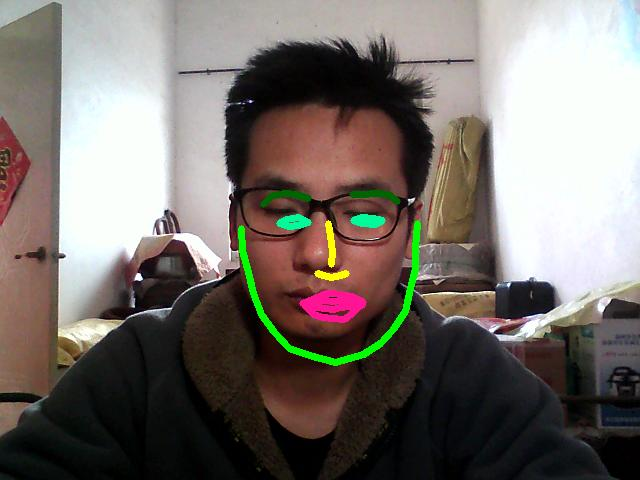

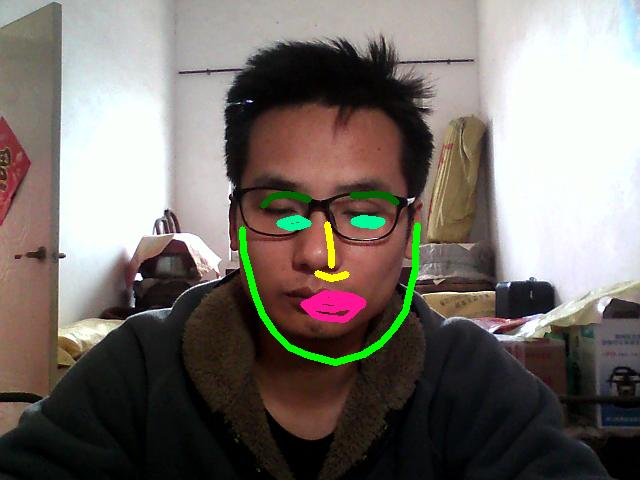

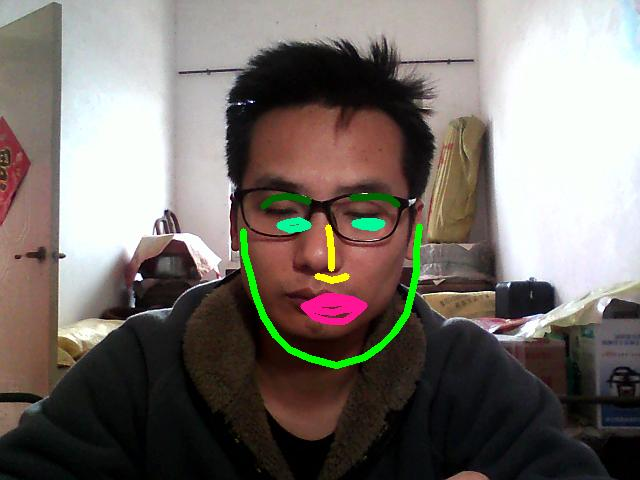

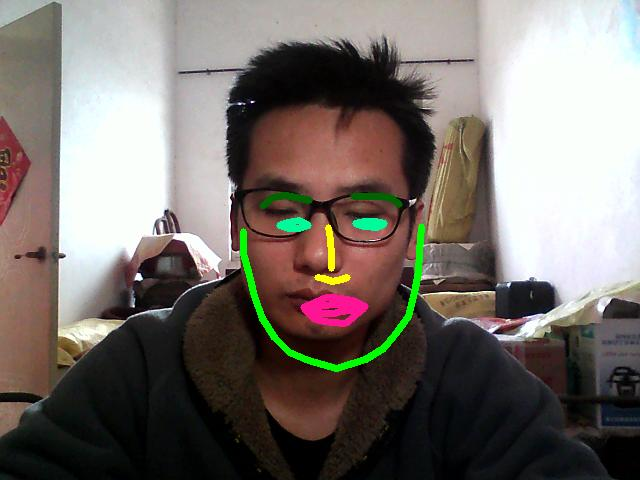

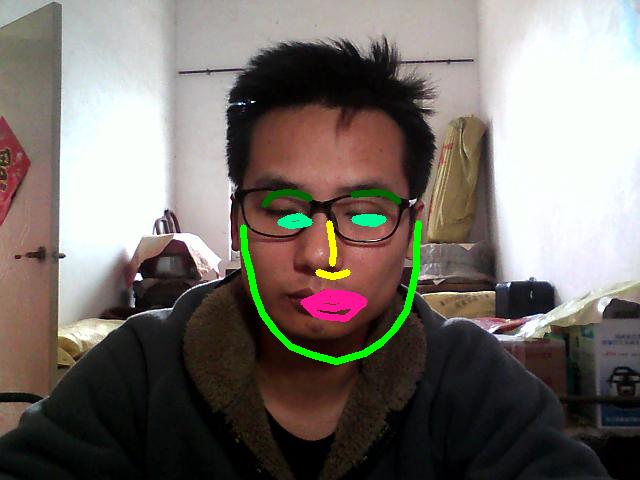

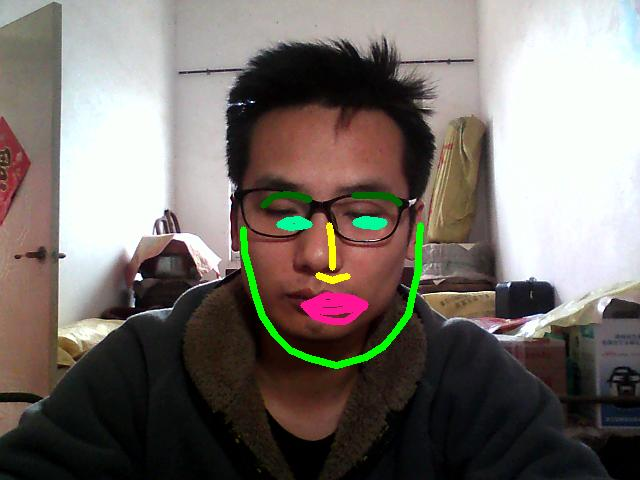

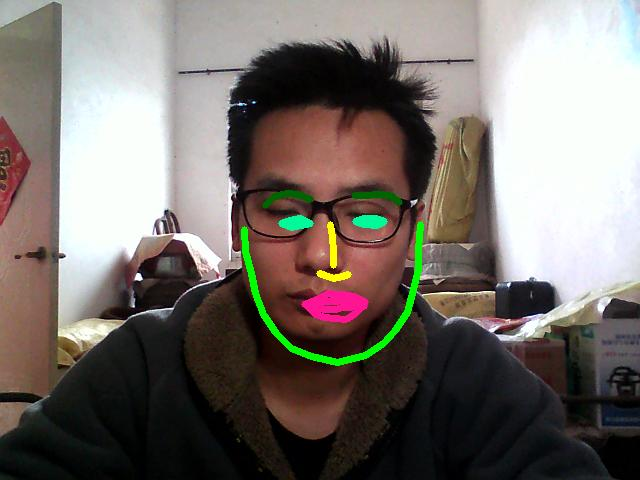

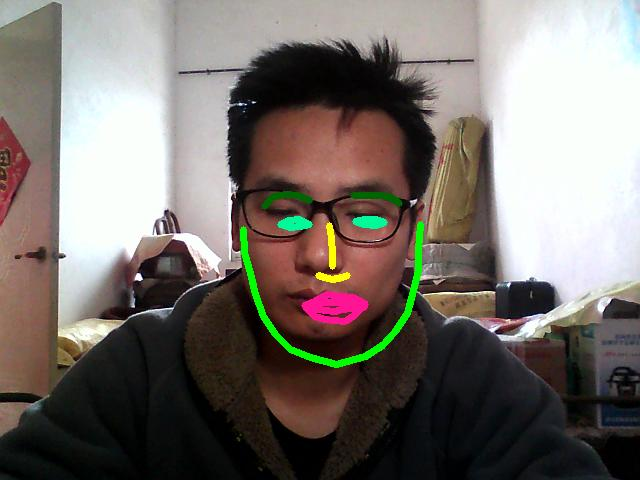

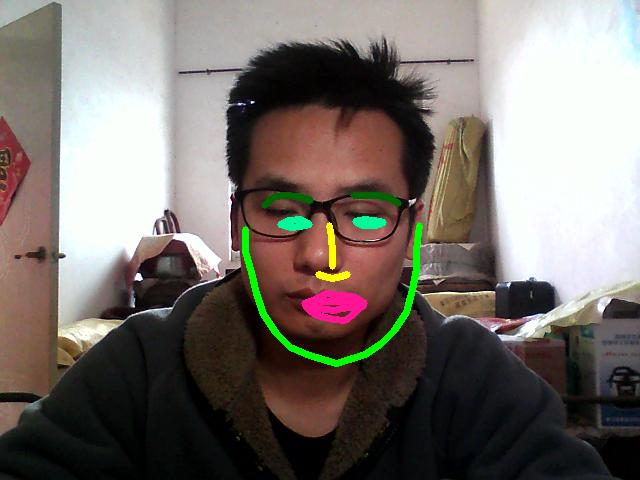

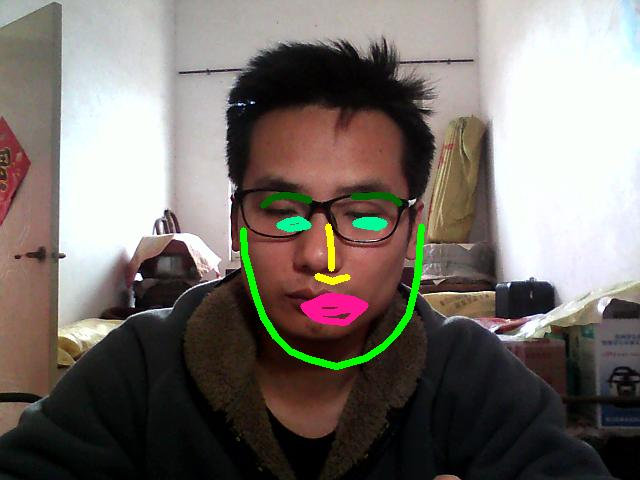

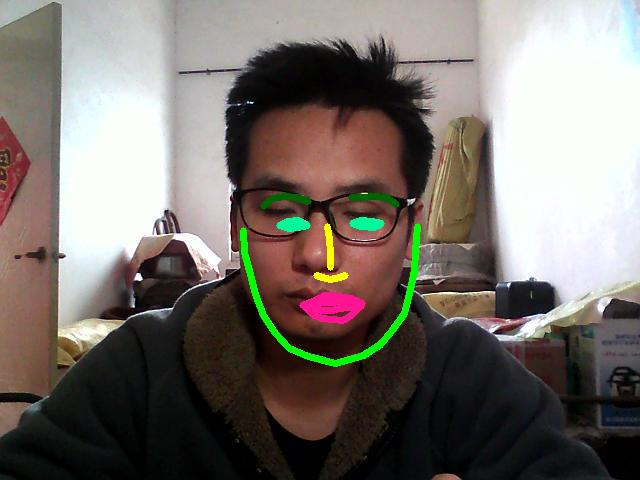

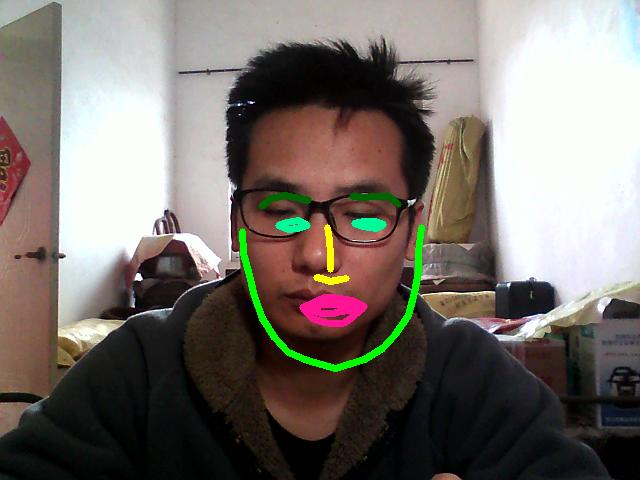

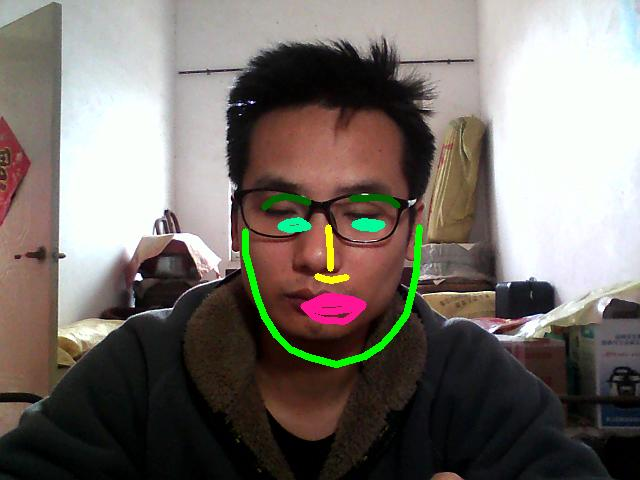

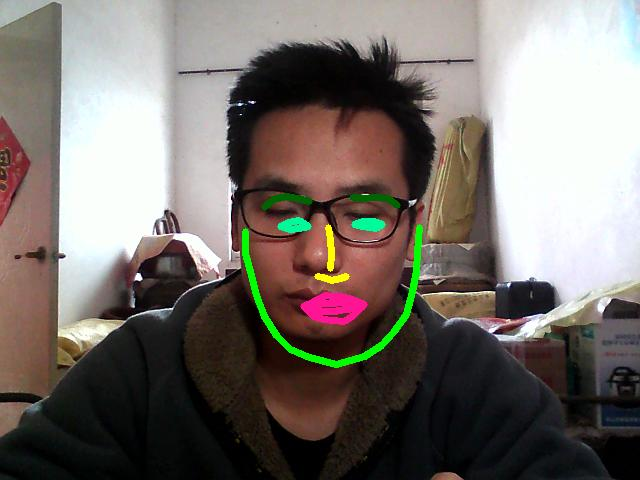

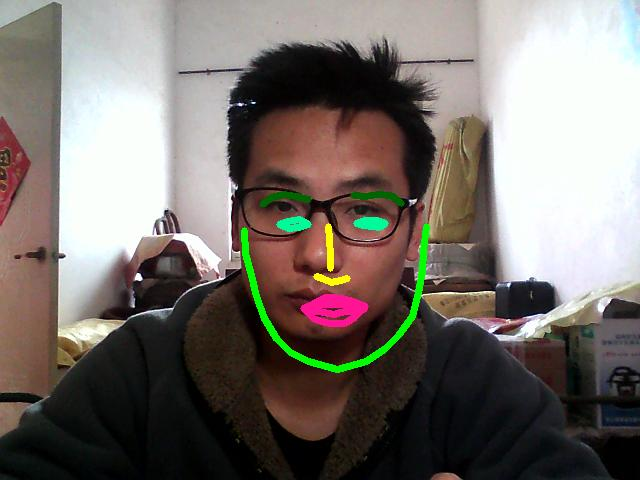

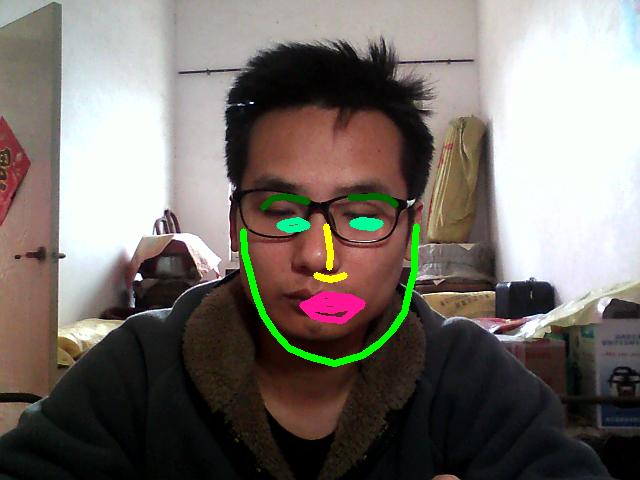

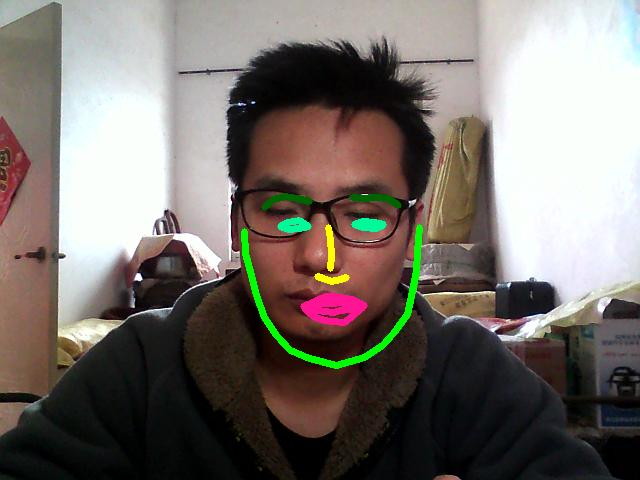

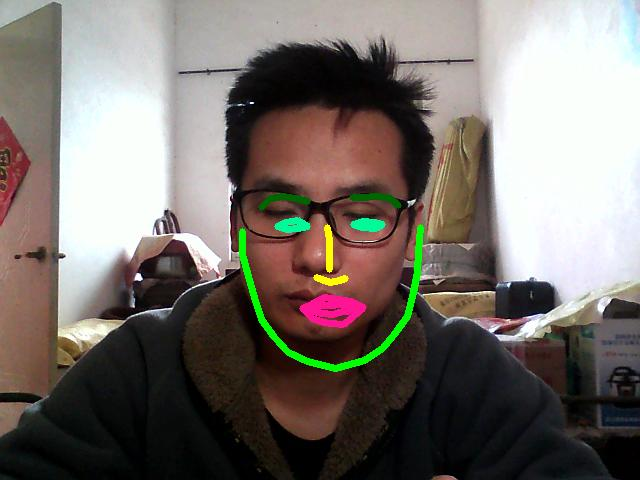

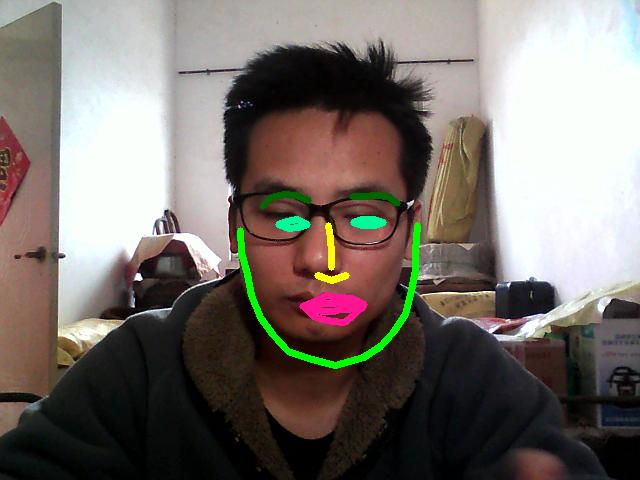

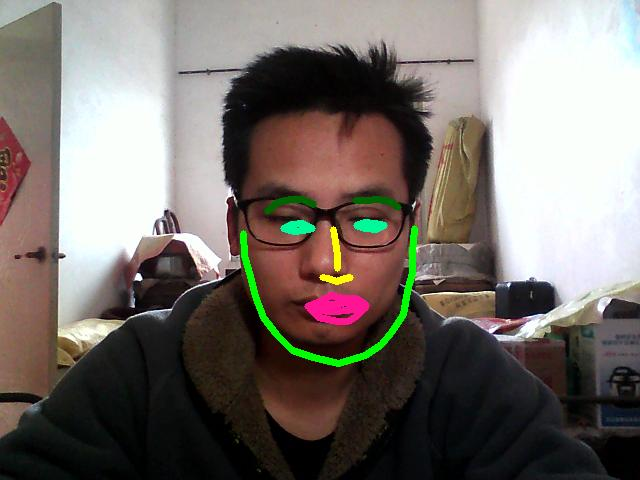

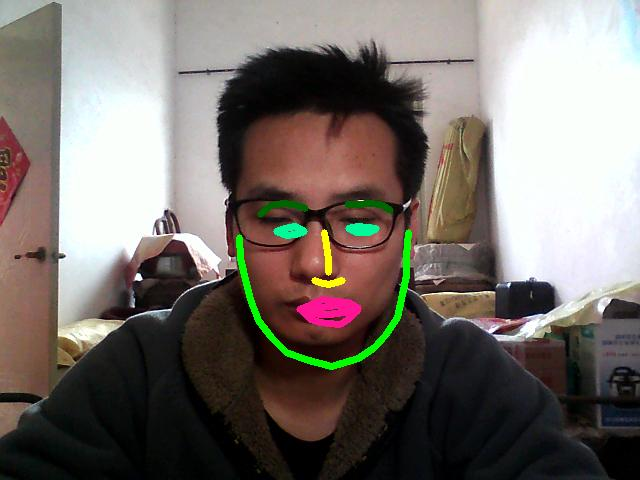

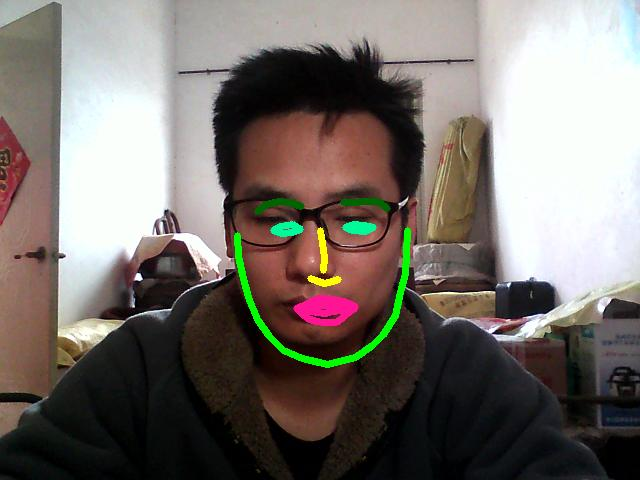

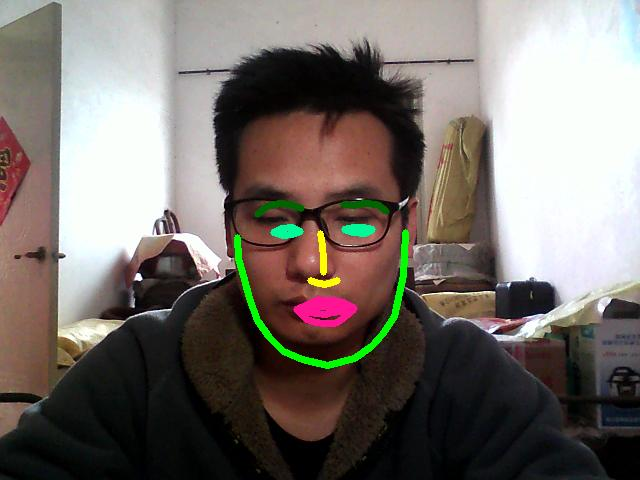

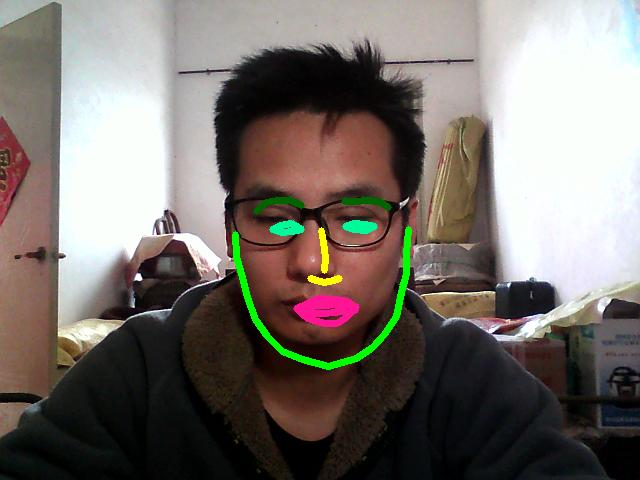

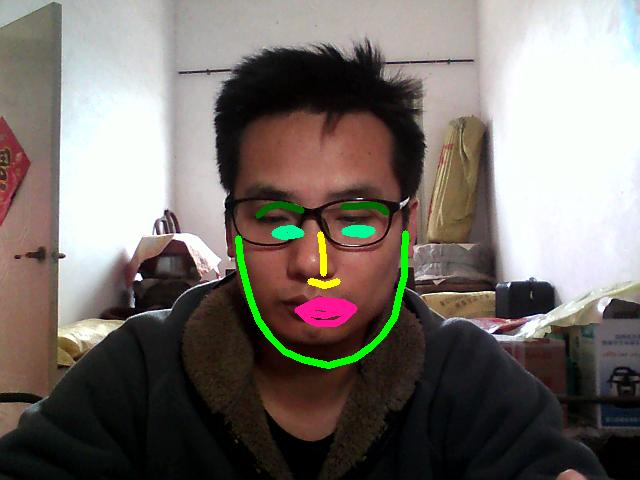

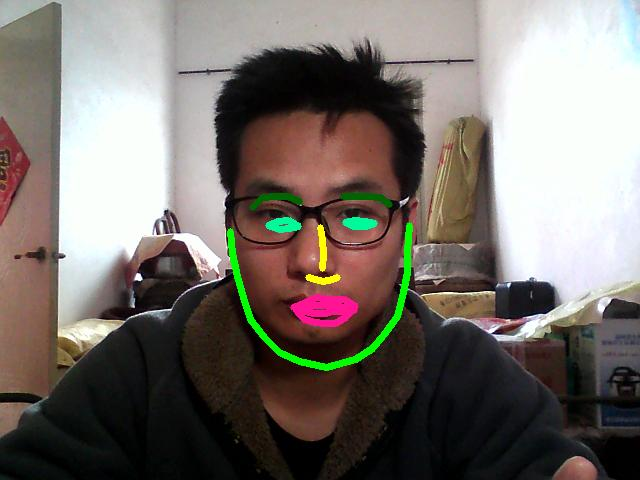

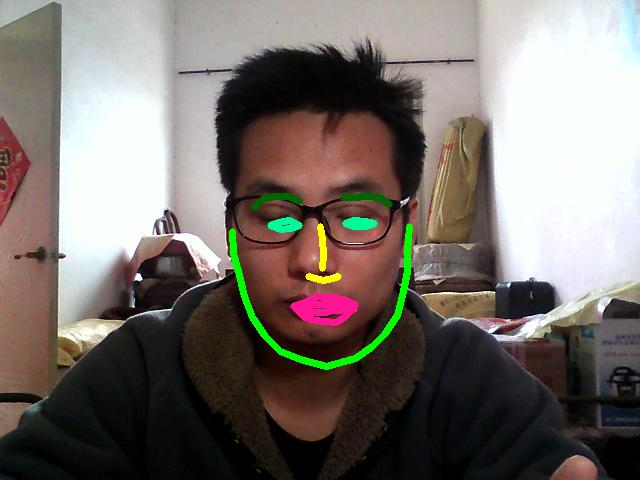

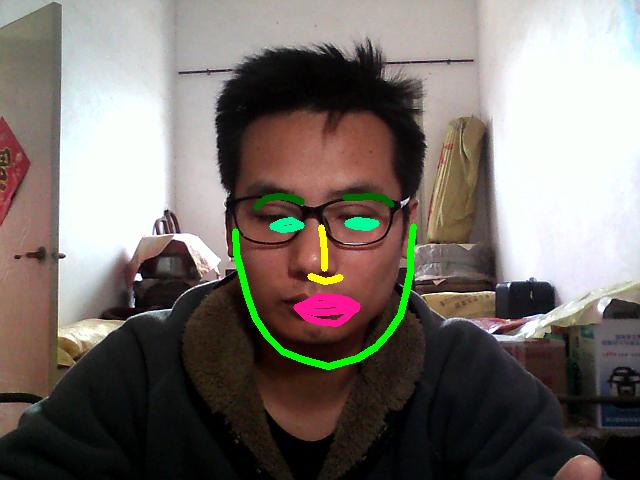

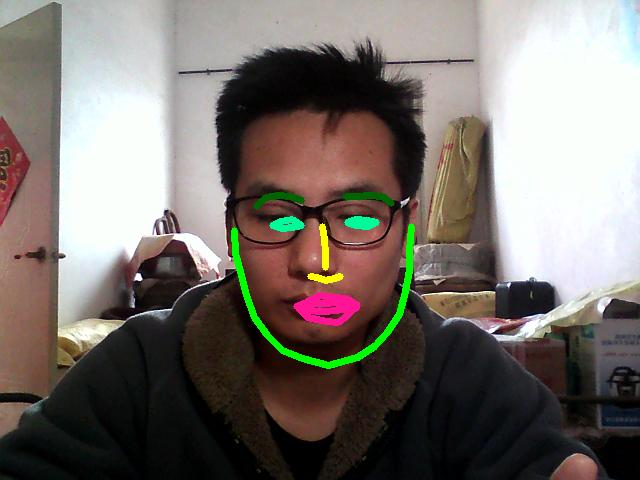

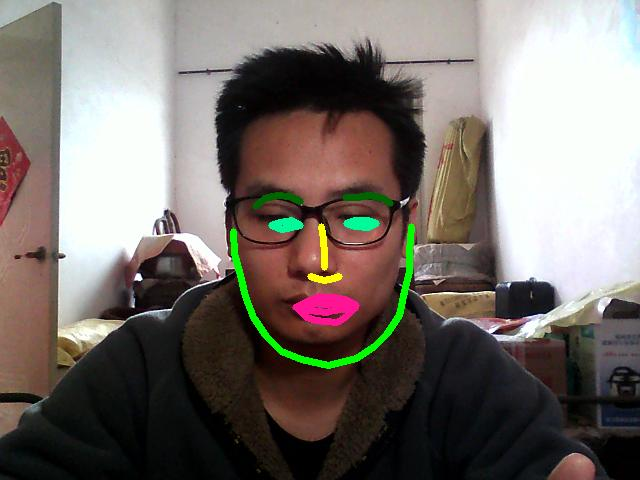

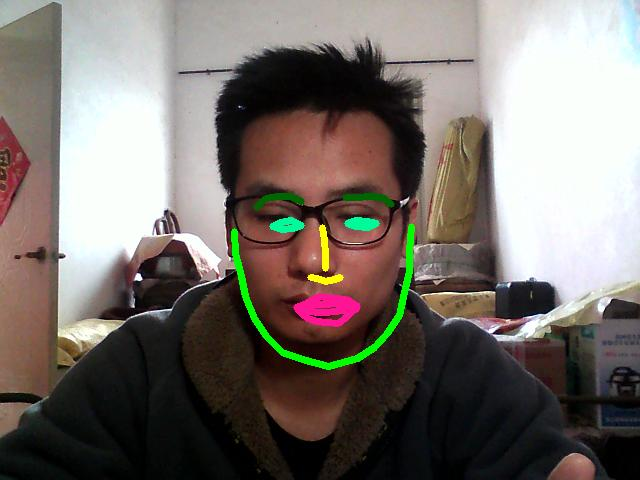

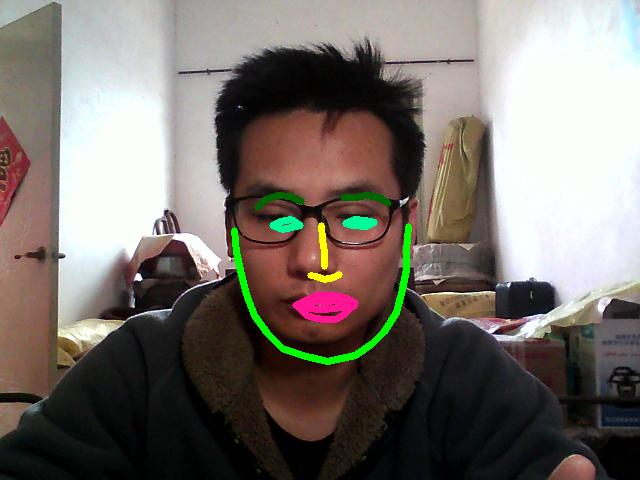

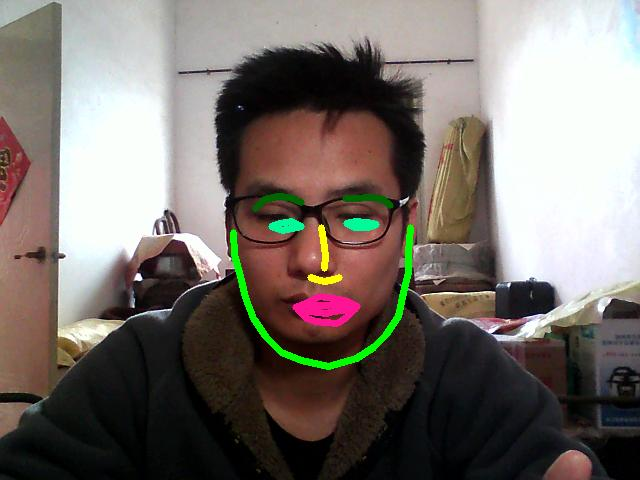

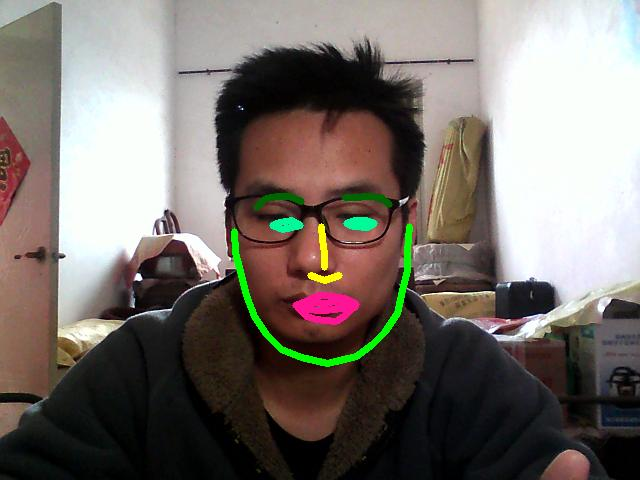

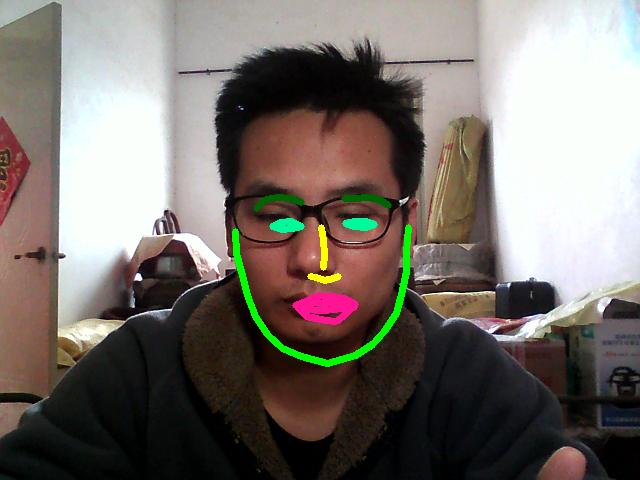

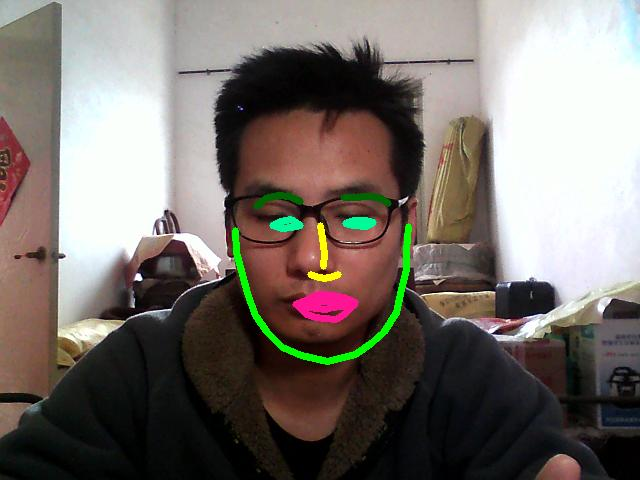

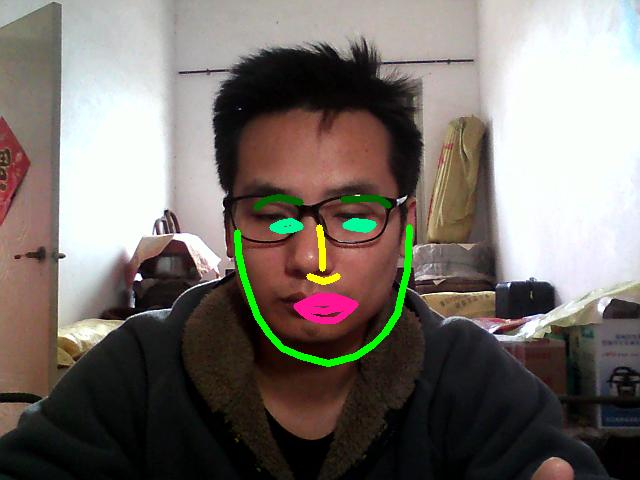

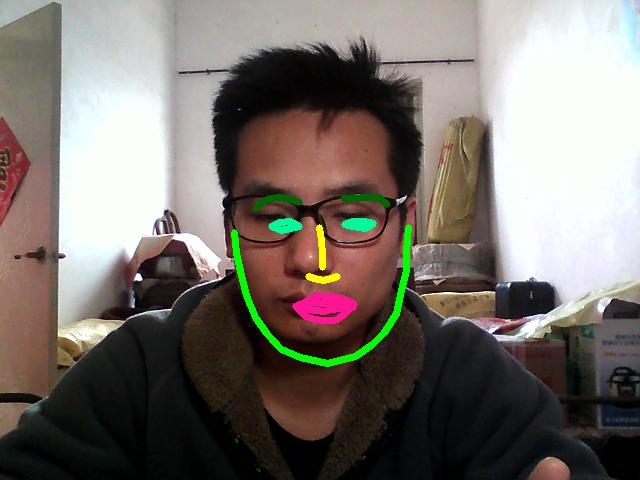

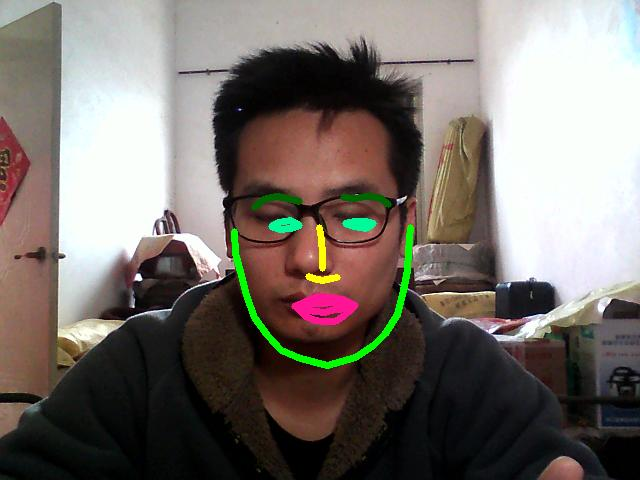

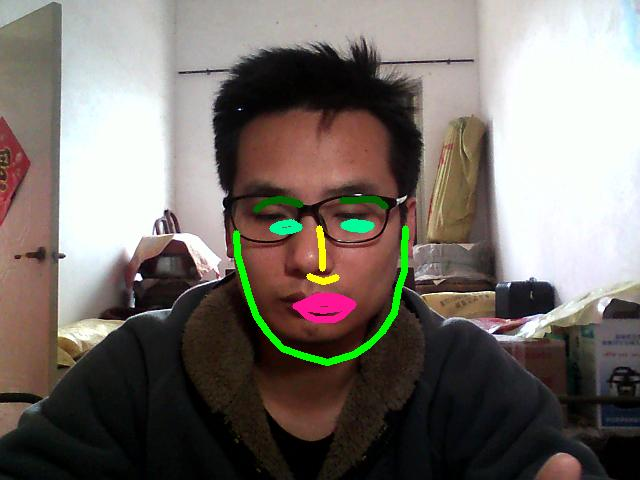

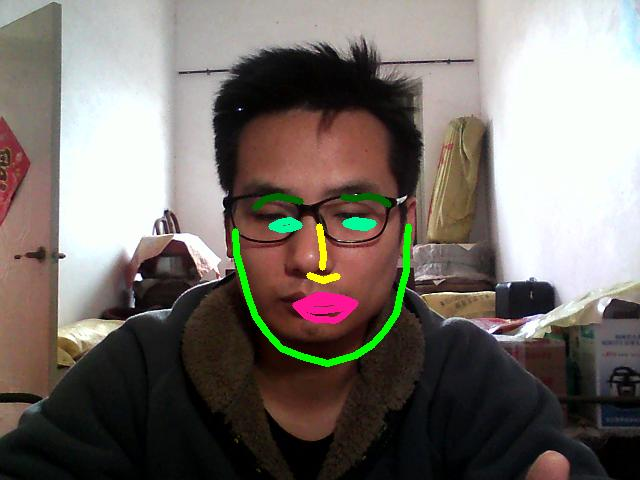

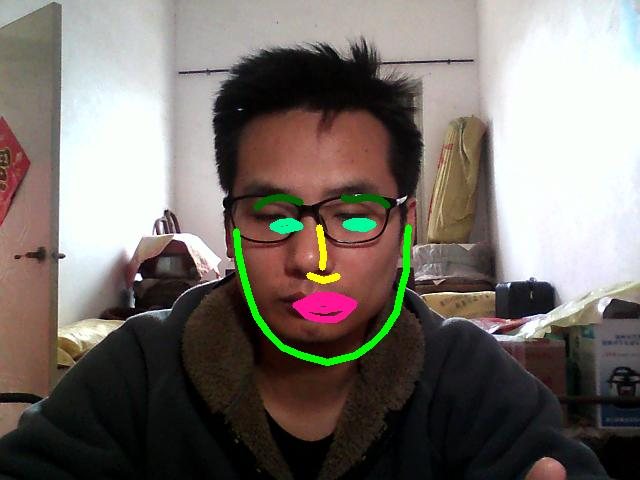

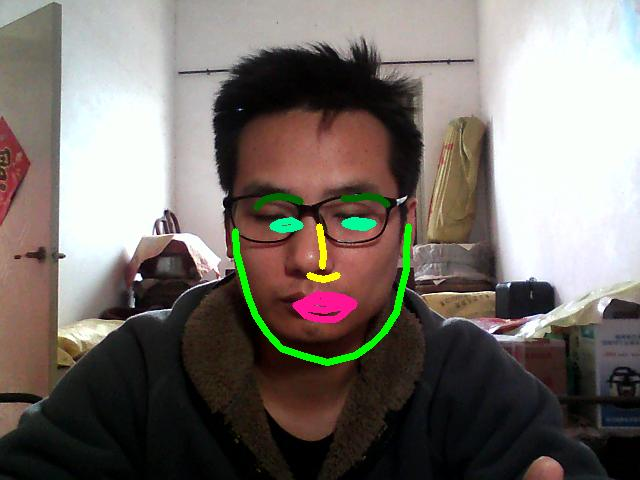

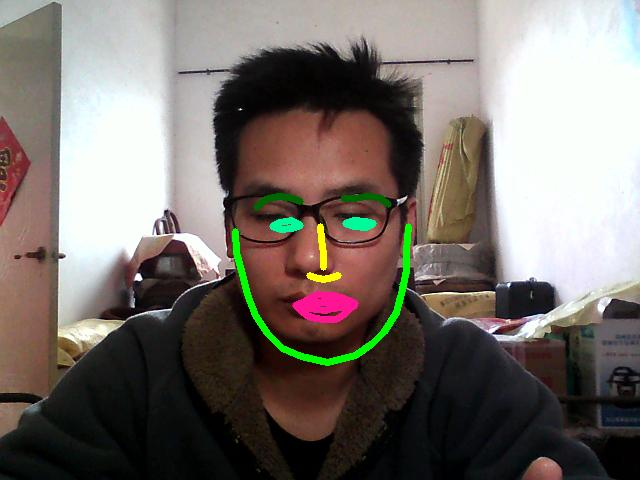

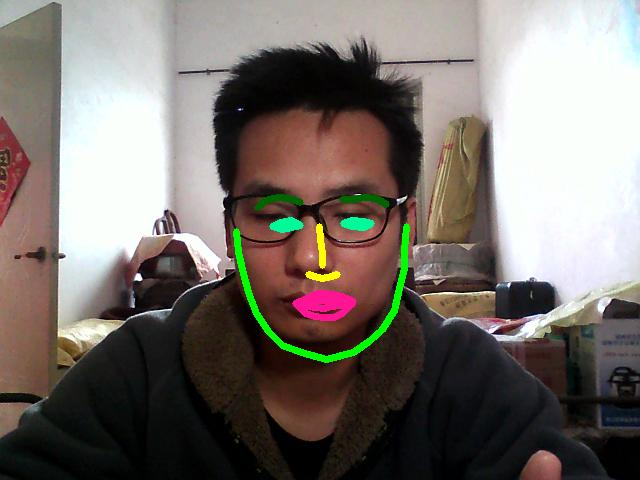

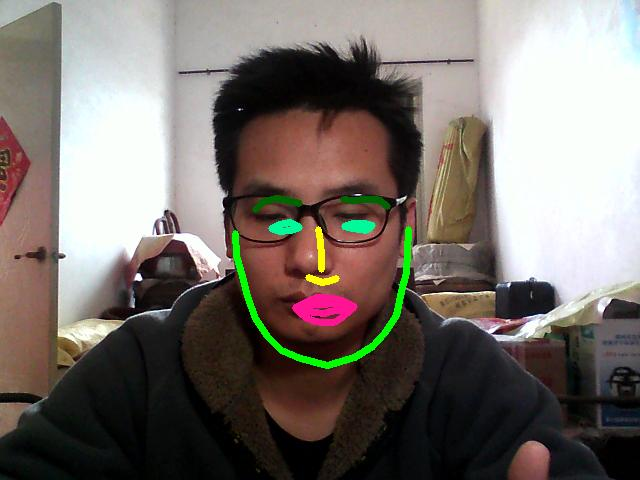

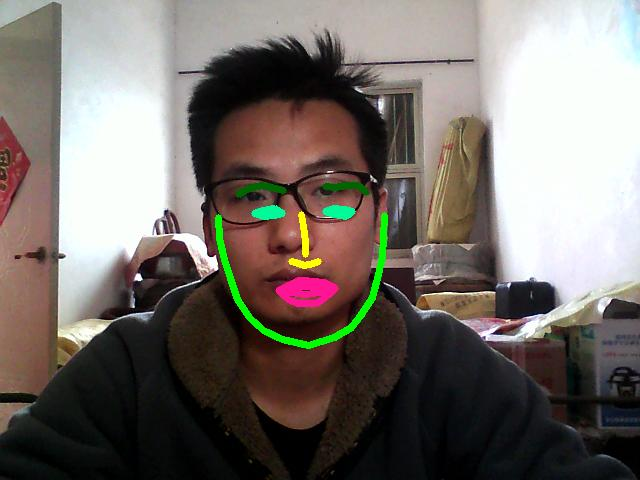

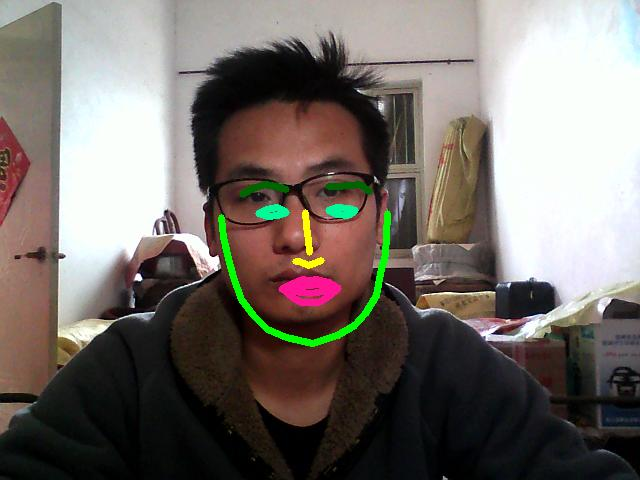

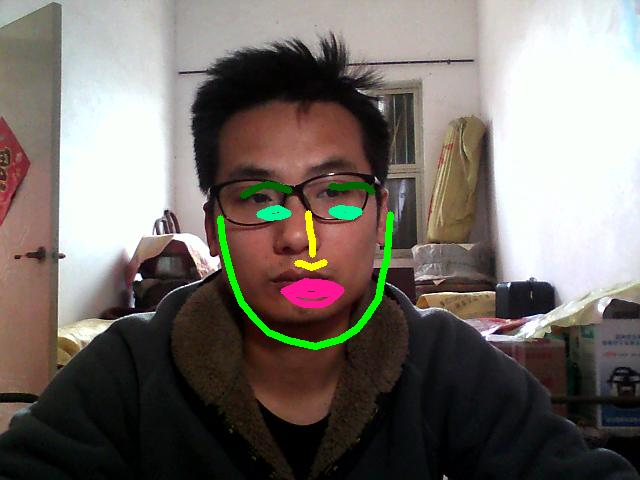

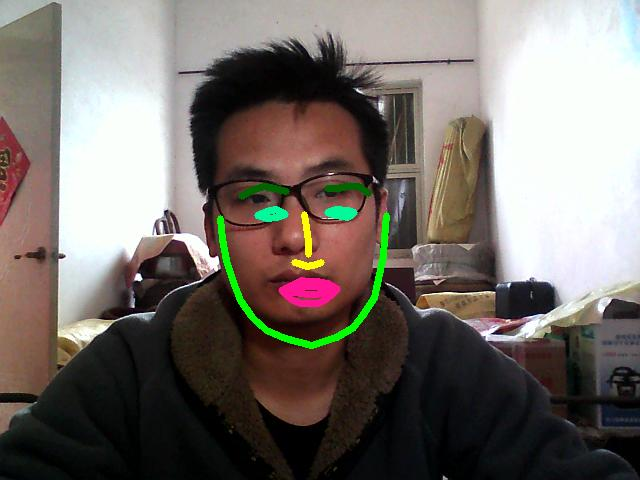

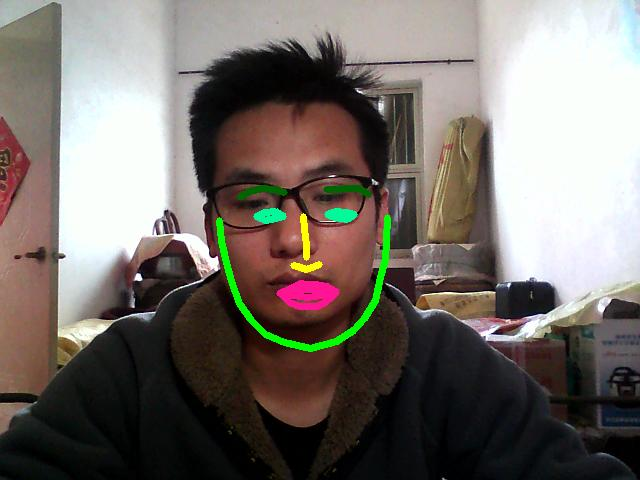

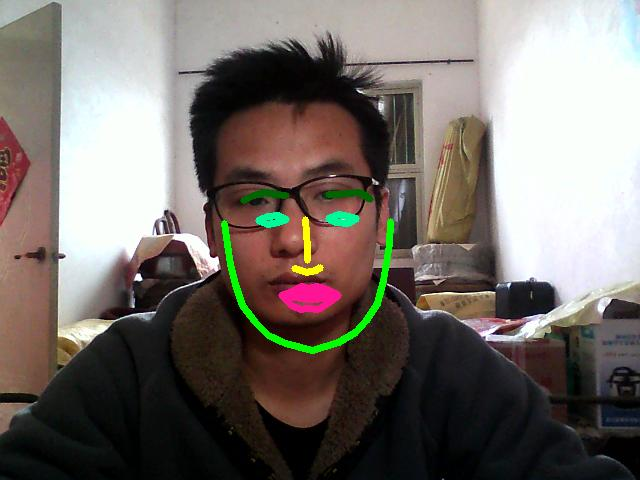

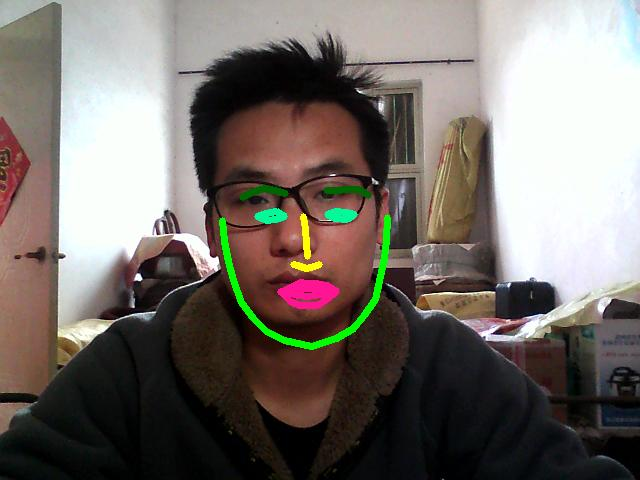

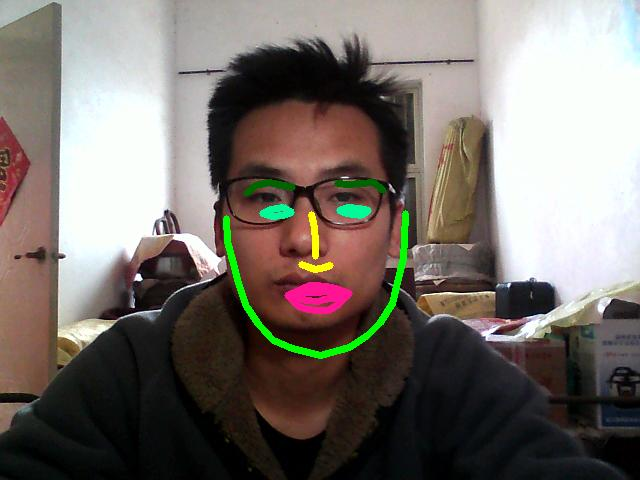

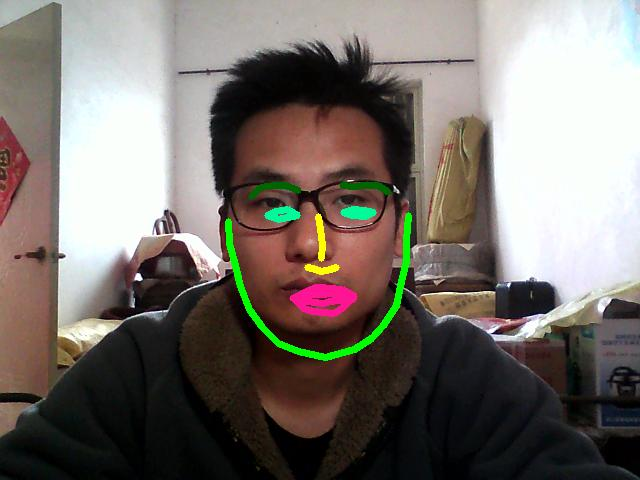

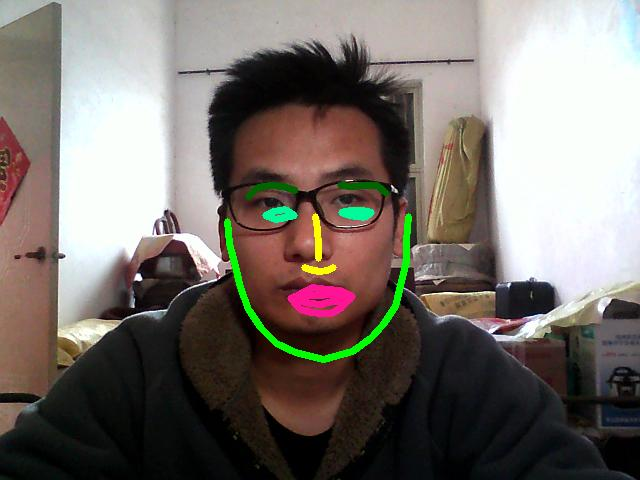

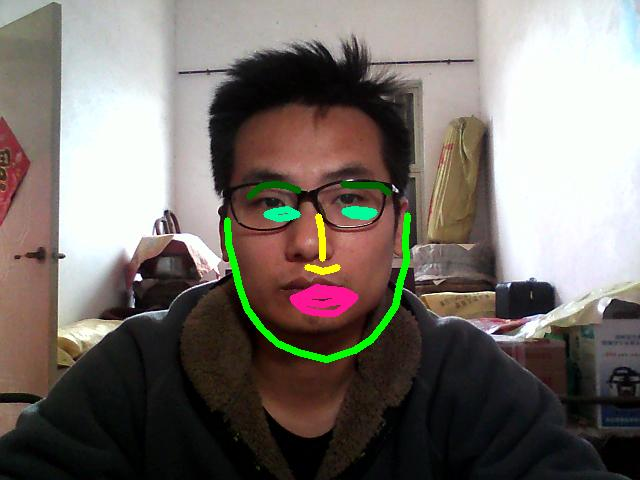

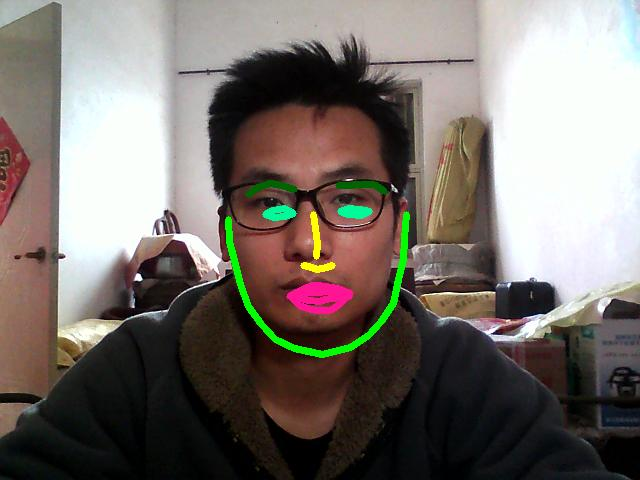

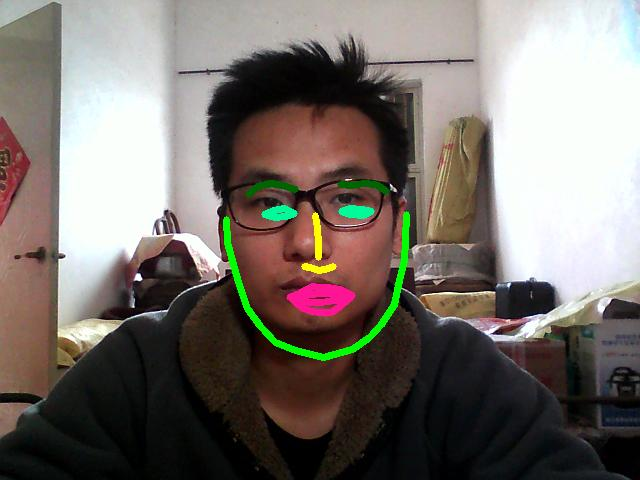

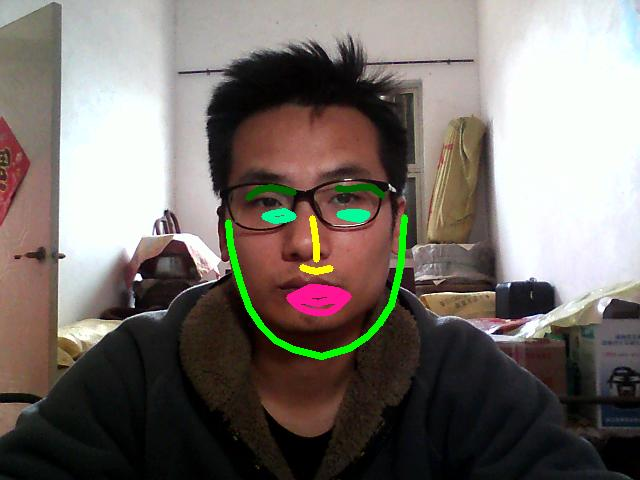

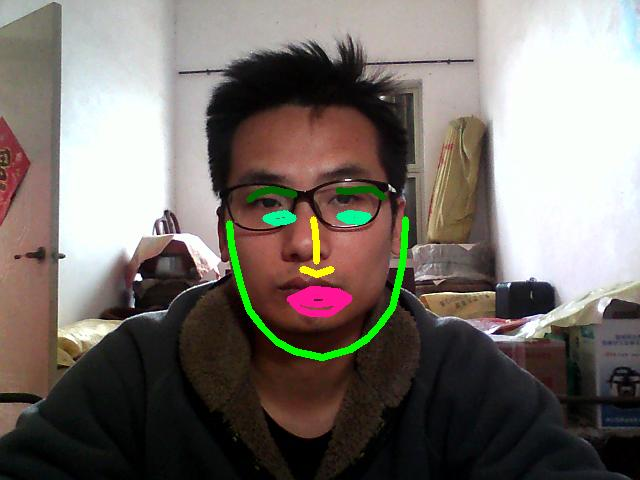

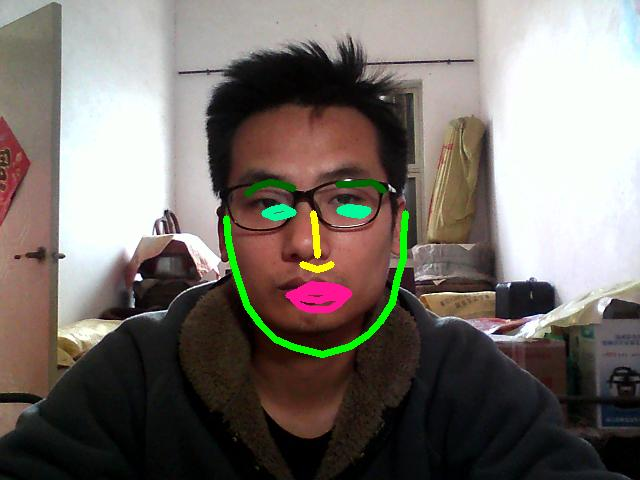

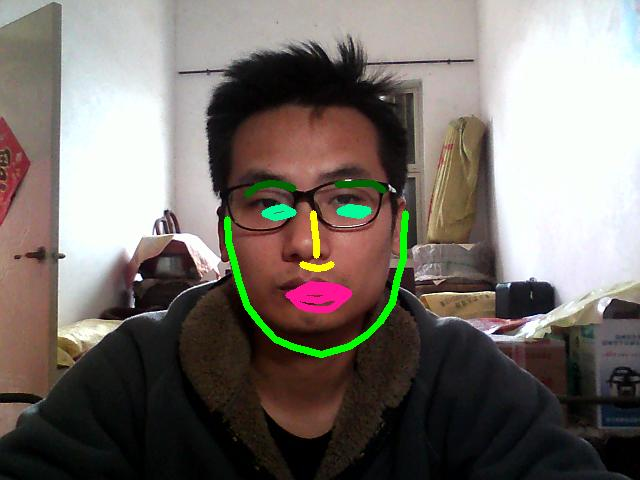

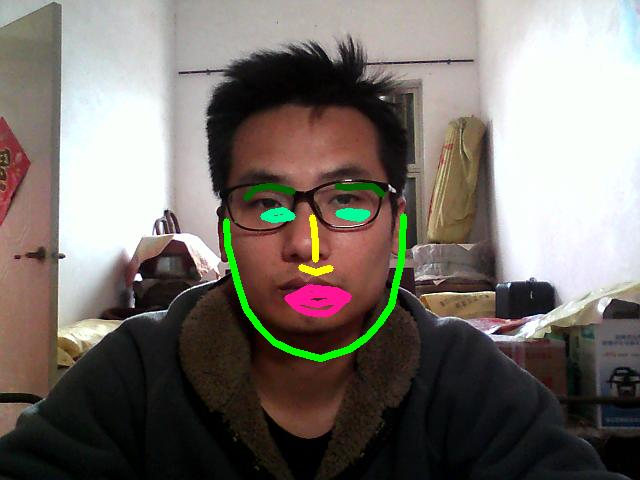

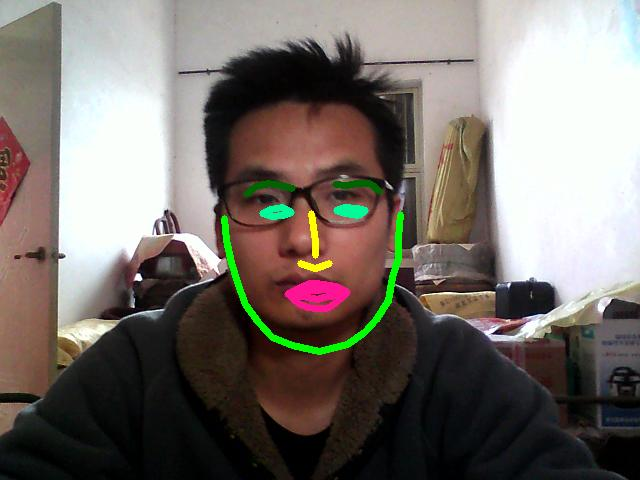

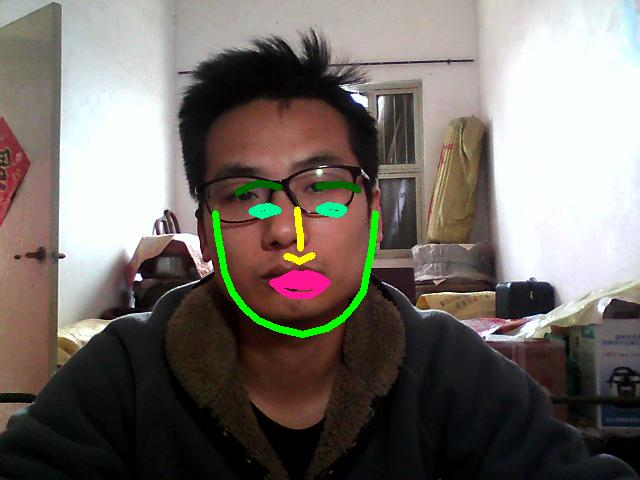

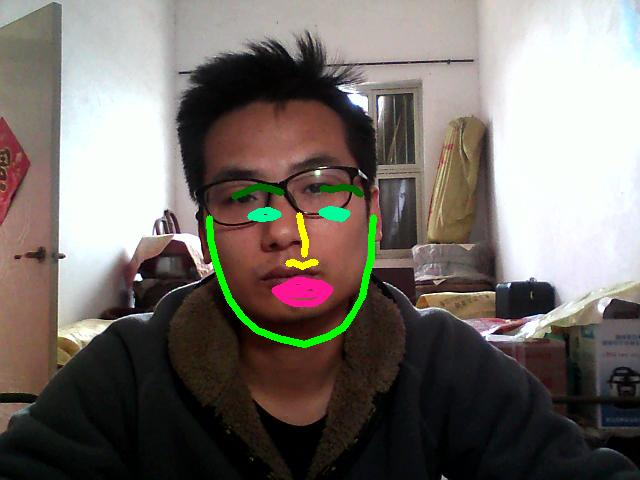

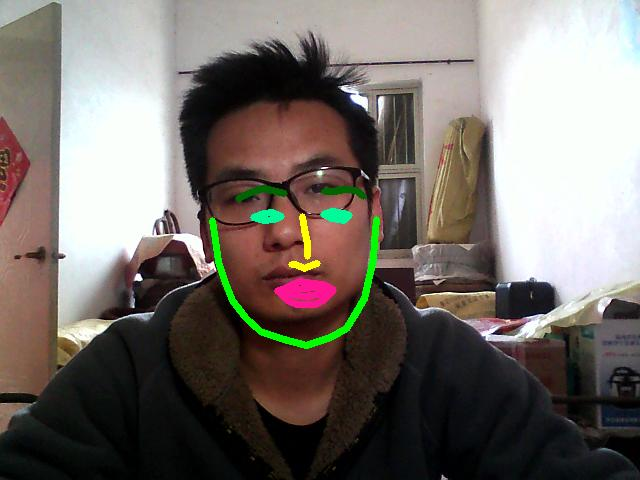

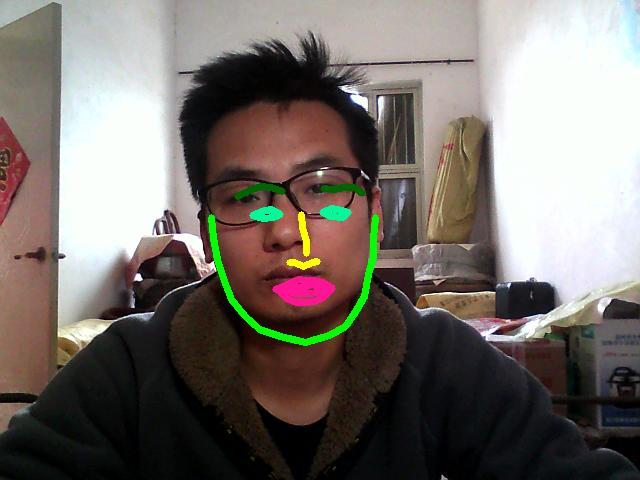

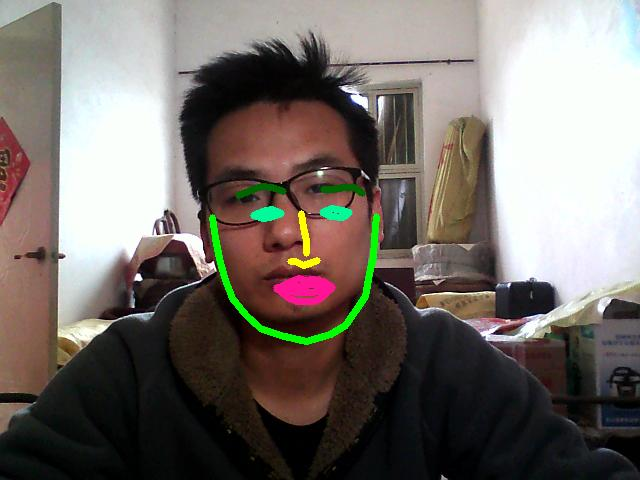

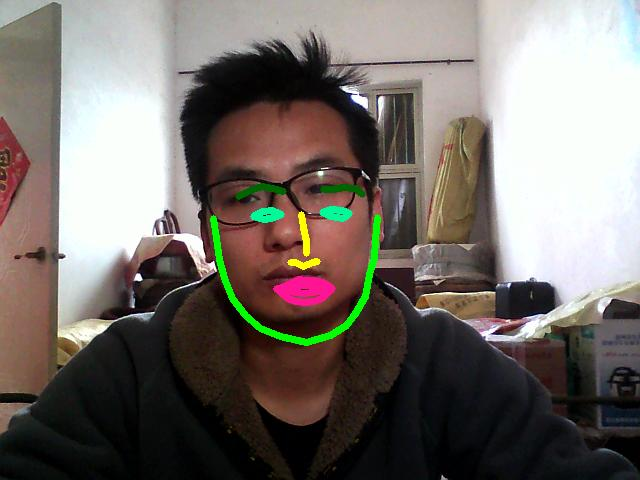

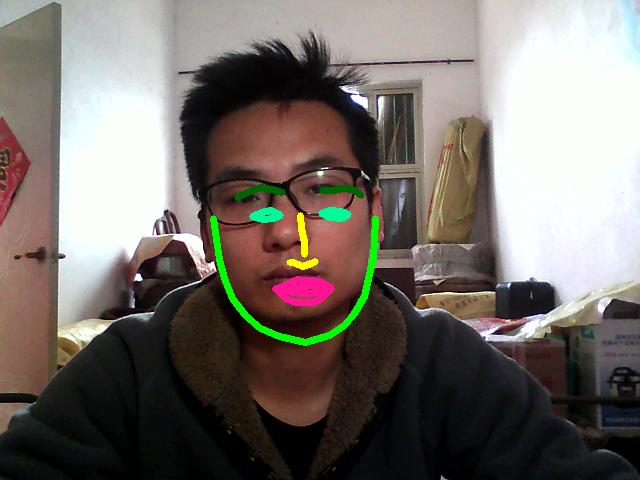

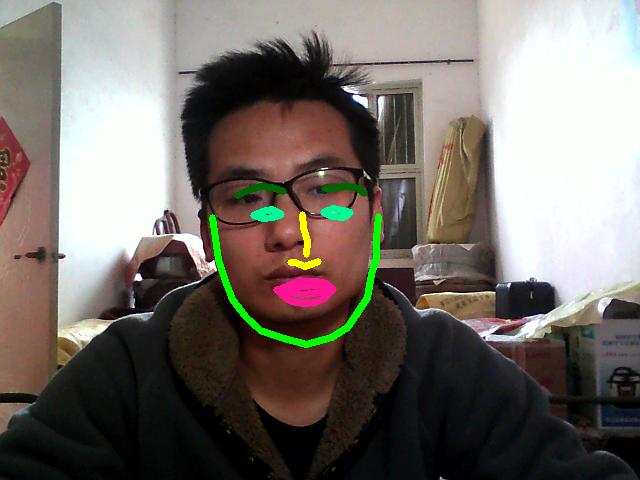

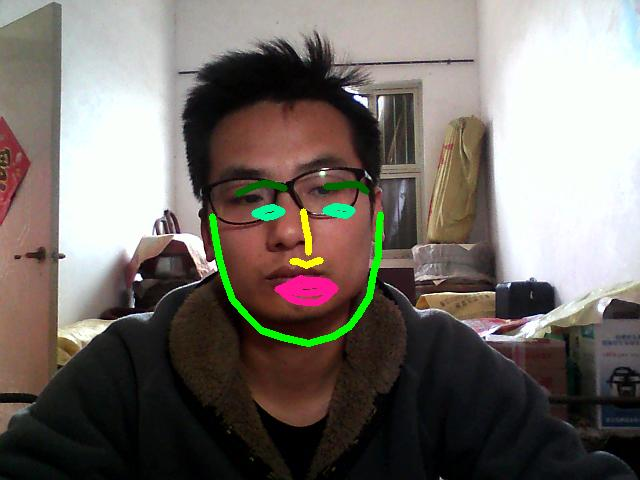

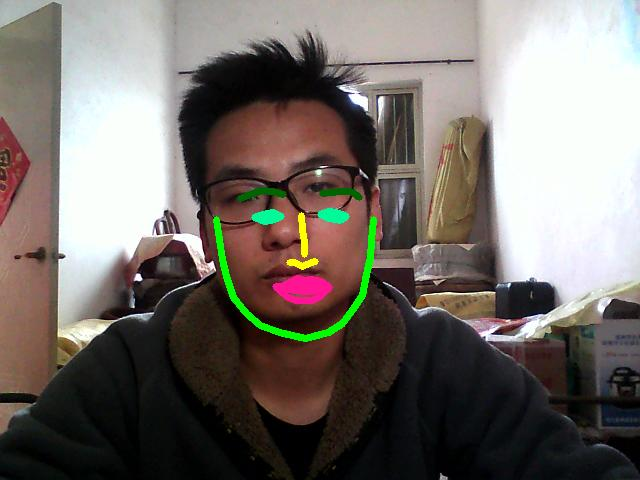

Stream stopped


In [9]:
import time
cap = cv2.VideoCapture(0)
save_video = True

if save_video:
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    # Define the codec and create VideoWriter object.The output is stored in 'outpput.avi' file.
    out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 4, (frame_width,frame_height))

try:
    while(True):
        frame = get_frame(cap)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
        frame = detect_keypoints(frame, 30)
        
        # write to video file
        if save_video:
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        
        showarray(frame)
         
        clear_output(wait=True)
except KeyboardInterrupt:
    cap.release()
    if save_video:
        out.release()
    print("Stream stopped")

The wabcam code is based on the [displaying webcam video in IPython notebook](https://github.com/ktaletsk/NCCV/blob/master/Realtime_video_ipython.ipynb) project.